## Figures

### Utilisation, Overall, Quarterly

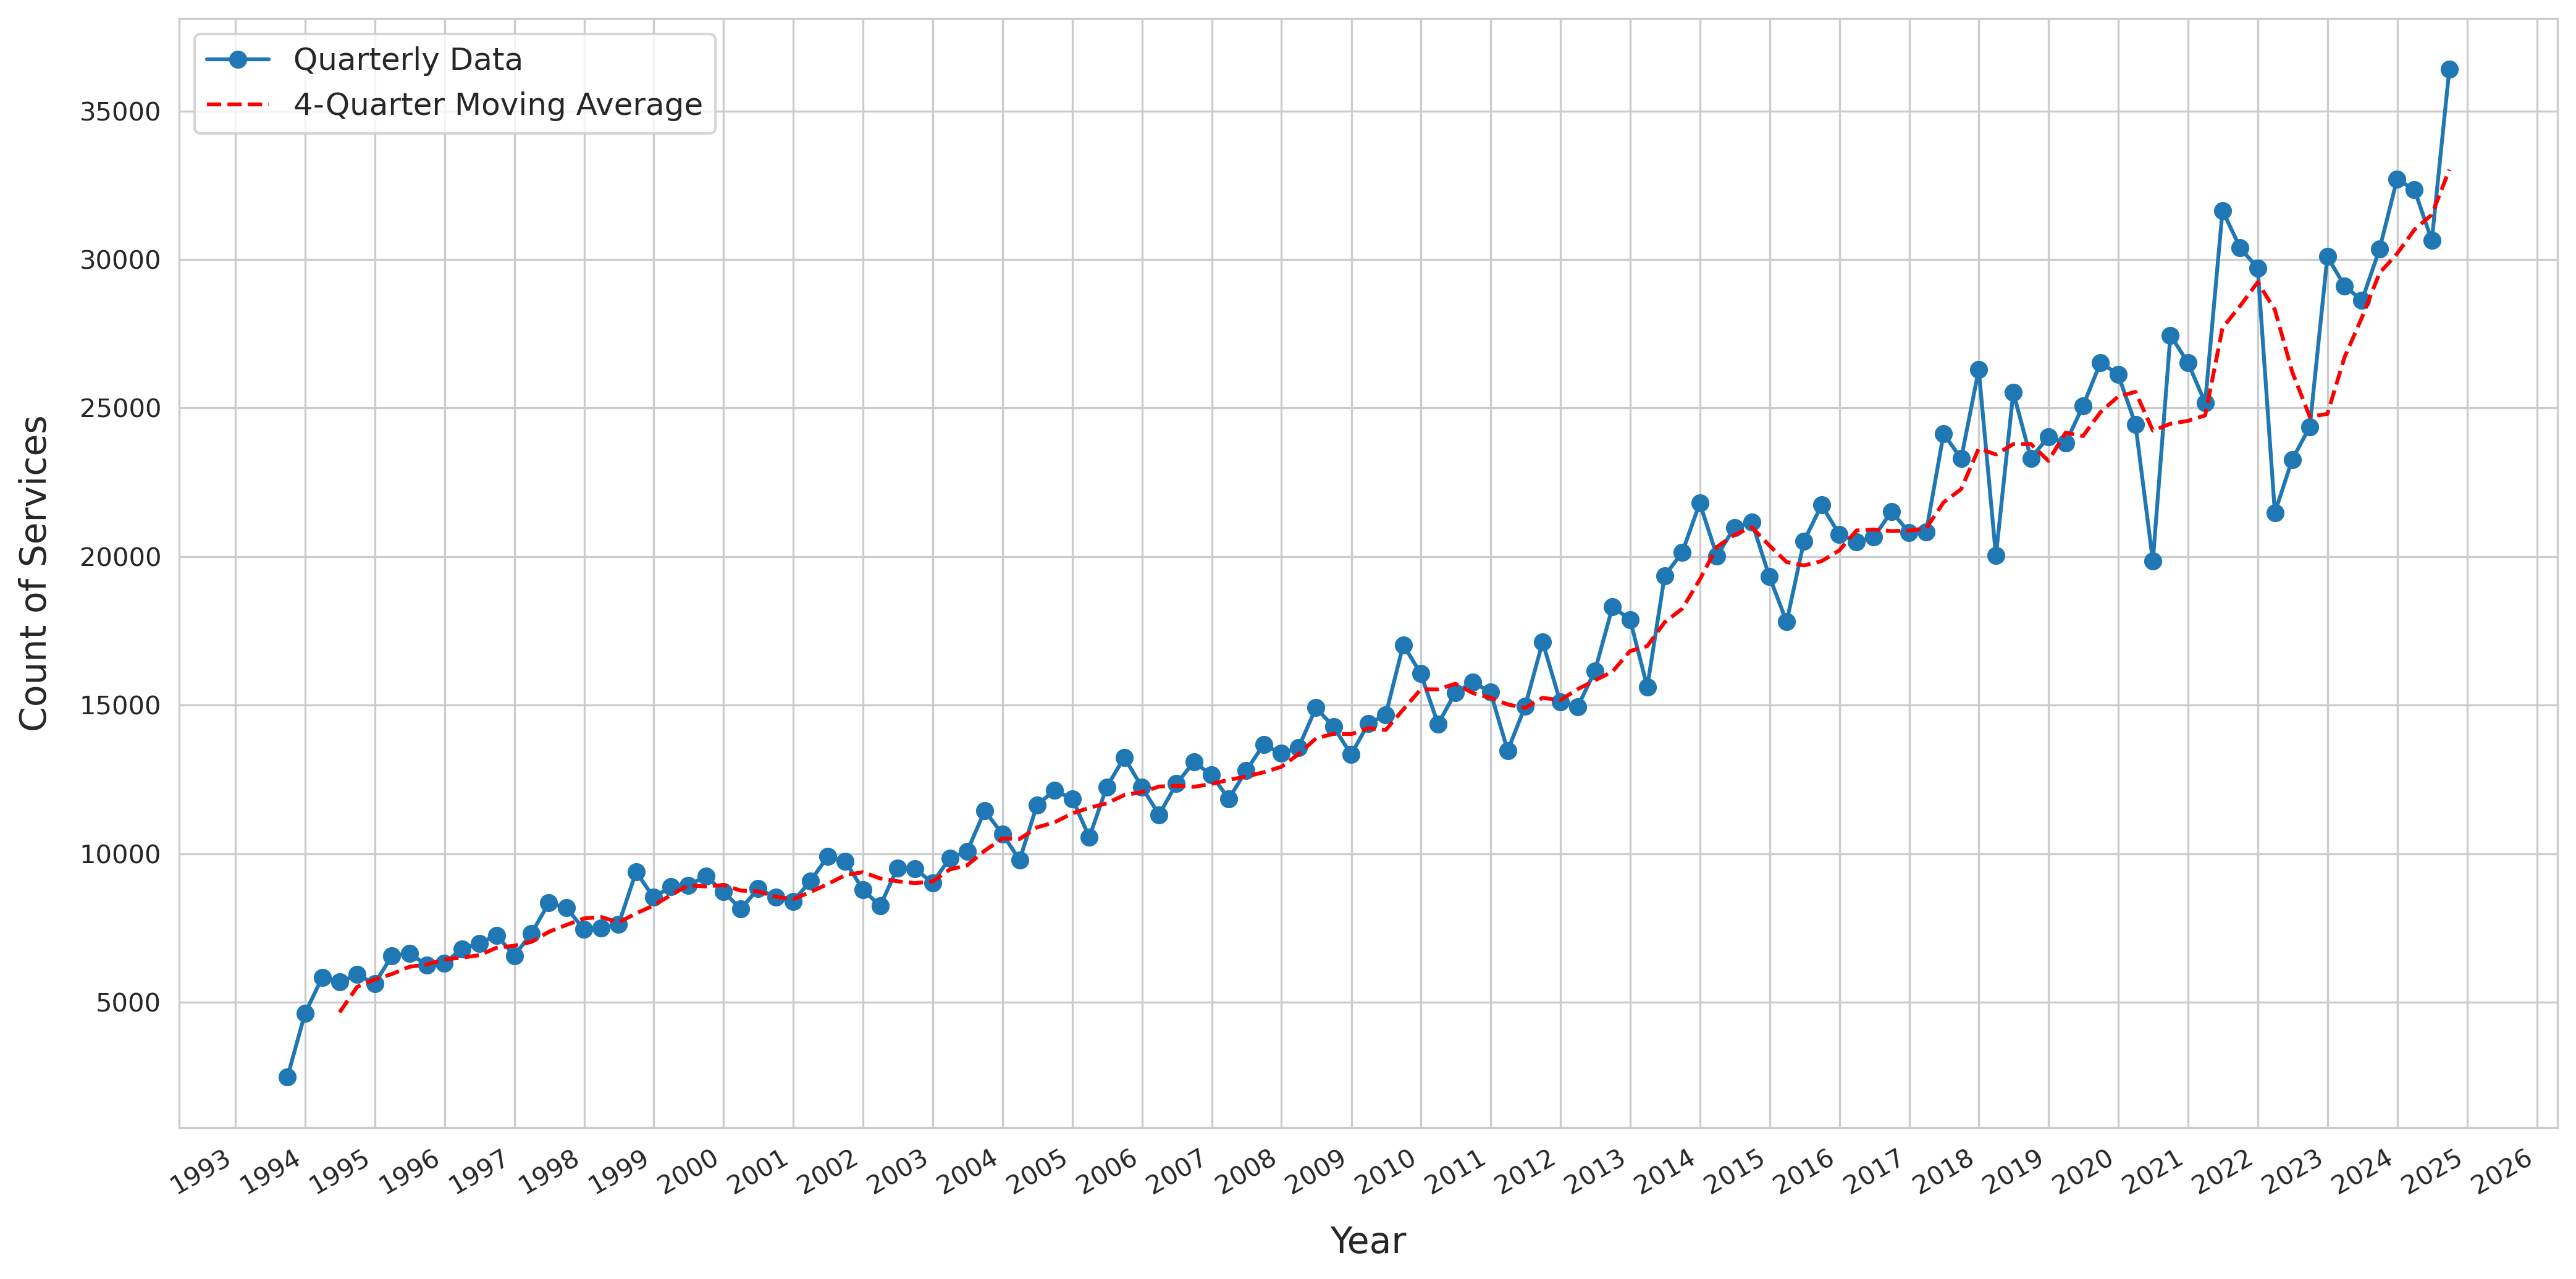

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Aggregate 'Value' by quarter across all items and states (using 'QE' for quarter-end)
quarterly_data = filtered_data['Value'].resample('QE').sum()

# Calculate a 3-period moving average for the trendline
quarterly_trendline = quarterly_data.rolling(window=4).mean()

# -- Plotting --
# Use Seaborn to set a clean style
sns.set_style('whitegrid')

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)  # higher DPI for better print quality

# Plot the quarterly resampled data
ax.plot(quarterly_data.index, quarterly_data, marker='o', linestyle='-', color='#1f77b4', label='Quarterly Data')

# Add the 3-period moving average trendline
ax.plot(quarterly_trendline.index, quarterly_trendline, linestyle='--', color='red', label='4-Quarter Moving Average')

# Title and labels
ax.set_xlabel('Year', fontsize=14, labelpad=10)
ax.set_ylabel('Count of Services', fontsize=14, labelpad=10)

# Configure the x-axis to show one major tick per year and minor ticks each quarter
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a legend
ax.legend(fontsize=12)

# Improve the layout and the angle of x-axis labels
fig.autofmt_xdate()

plt.tight_layout()

# Display inline in Jupyter Notebook
plt.show()

# -- Save the figure as an SVG --
fig.savefig("QuarterlyValueWithMovingAverageTrendline.svg", format='svg', dpi=300)


### Utilisation, By Test, Quarterly

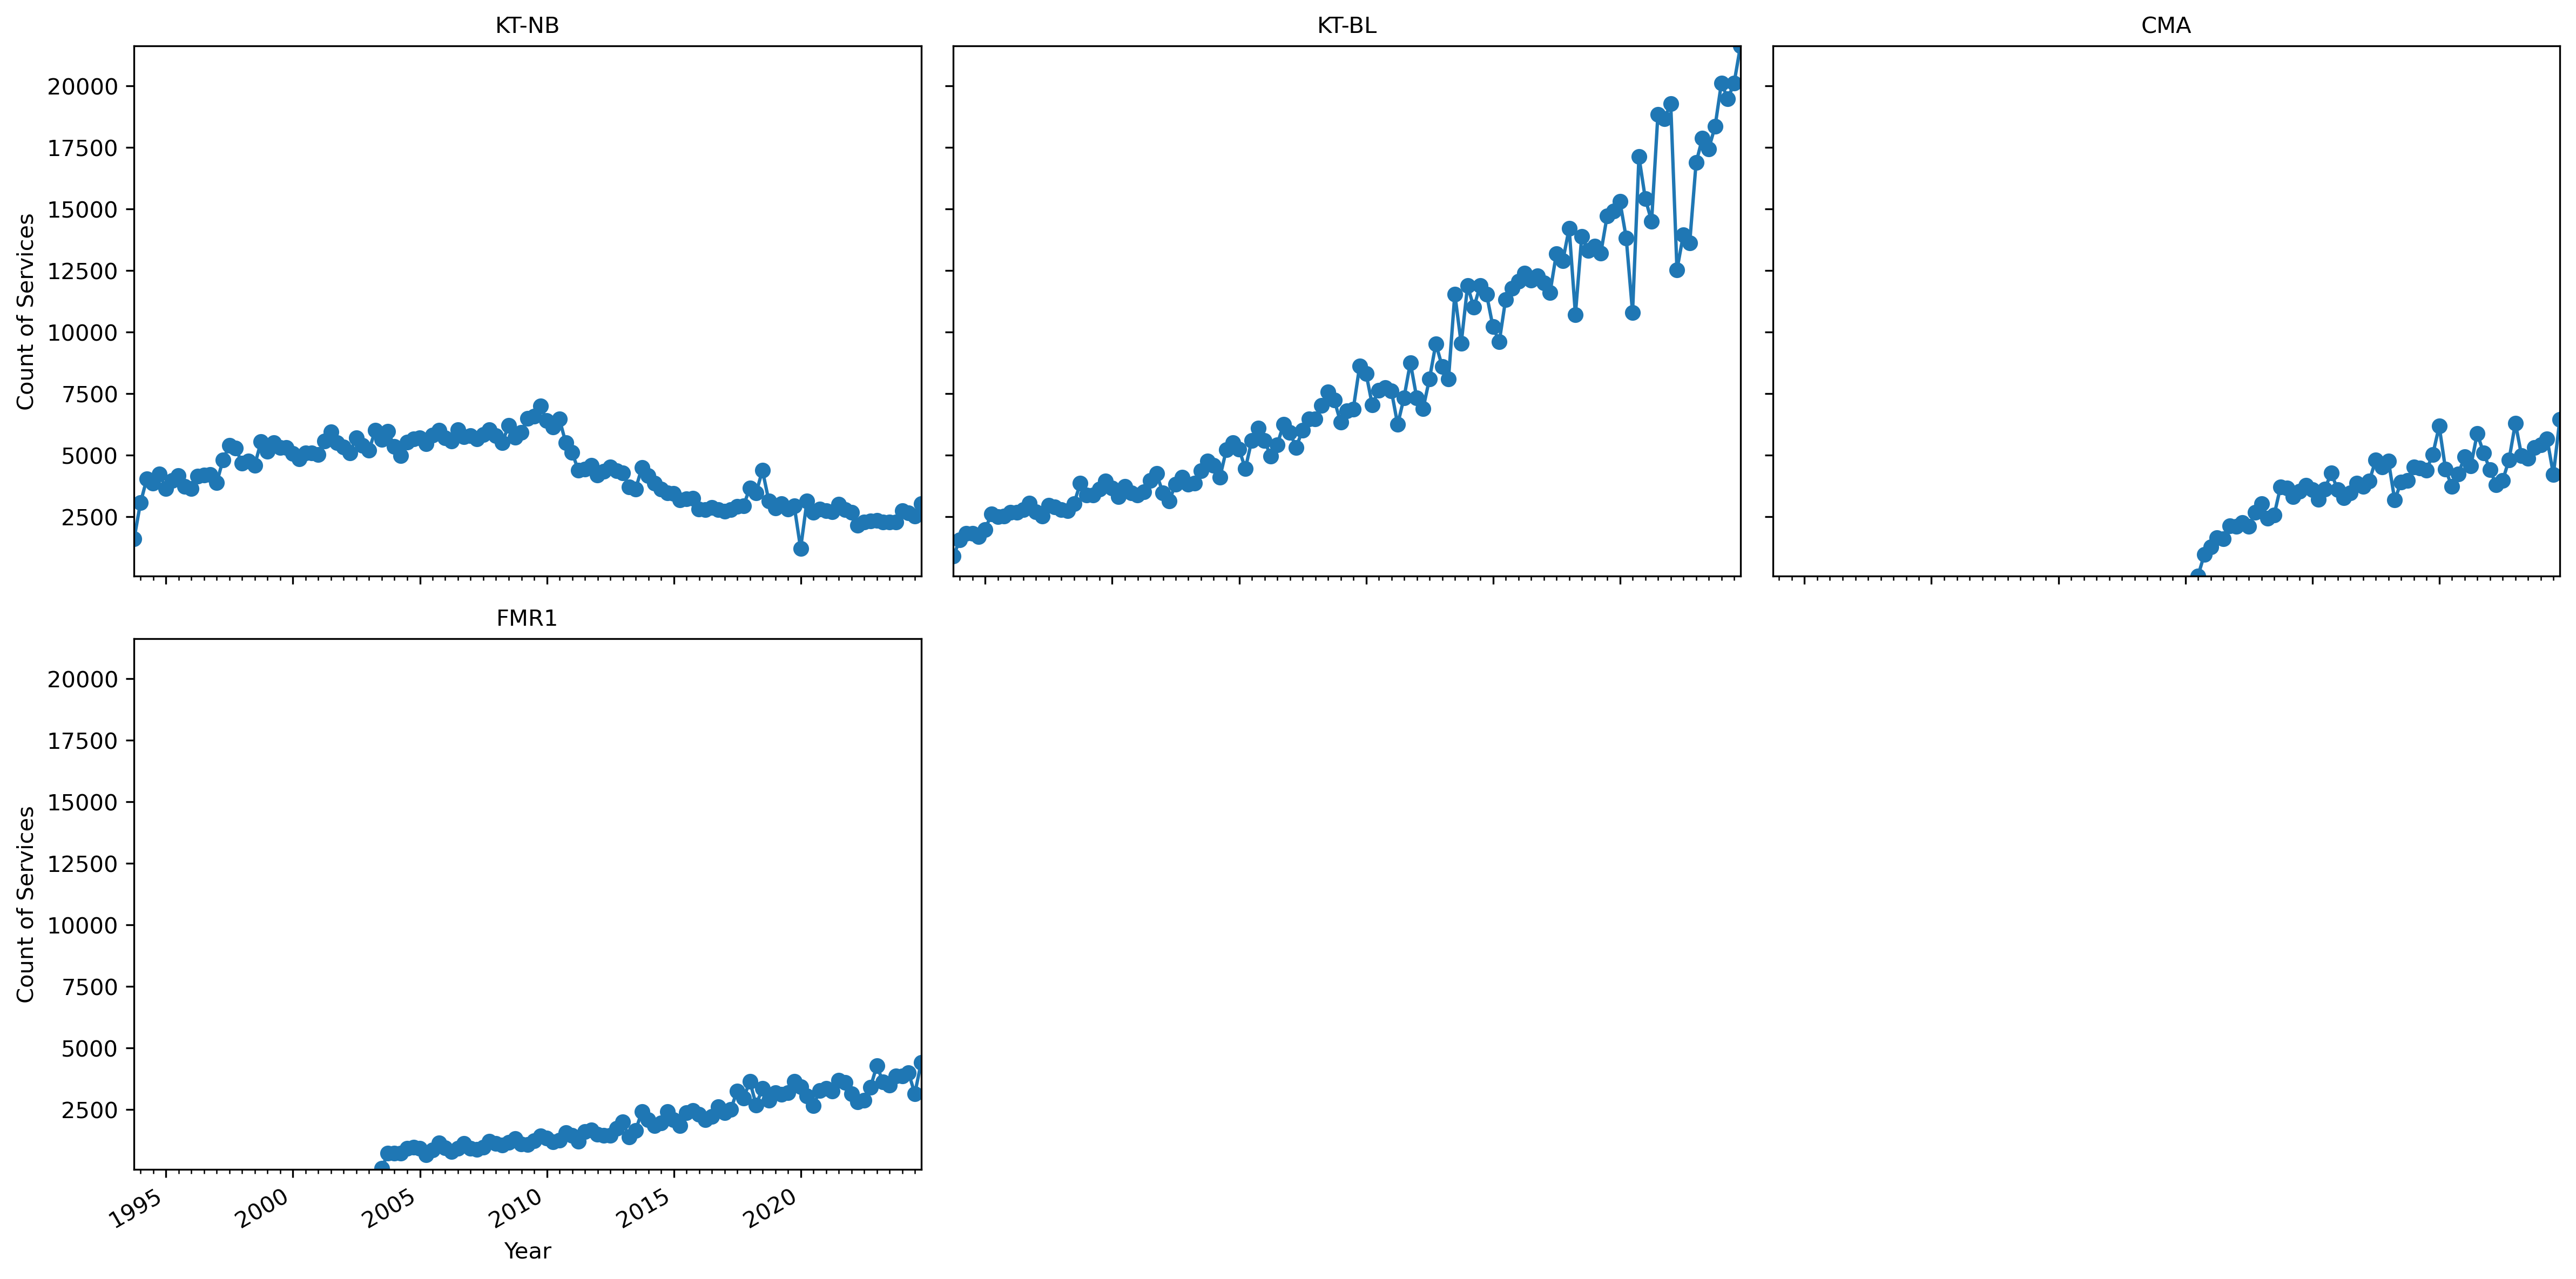

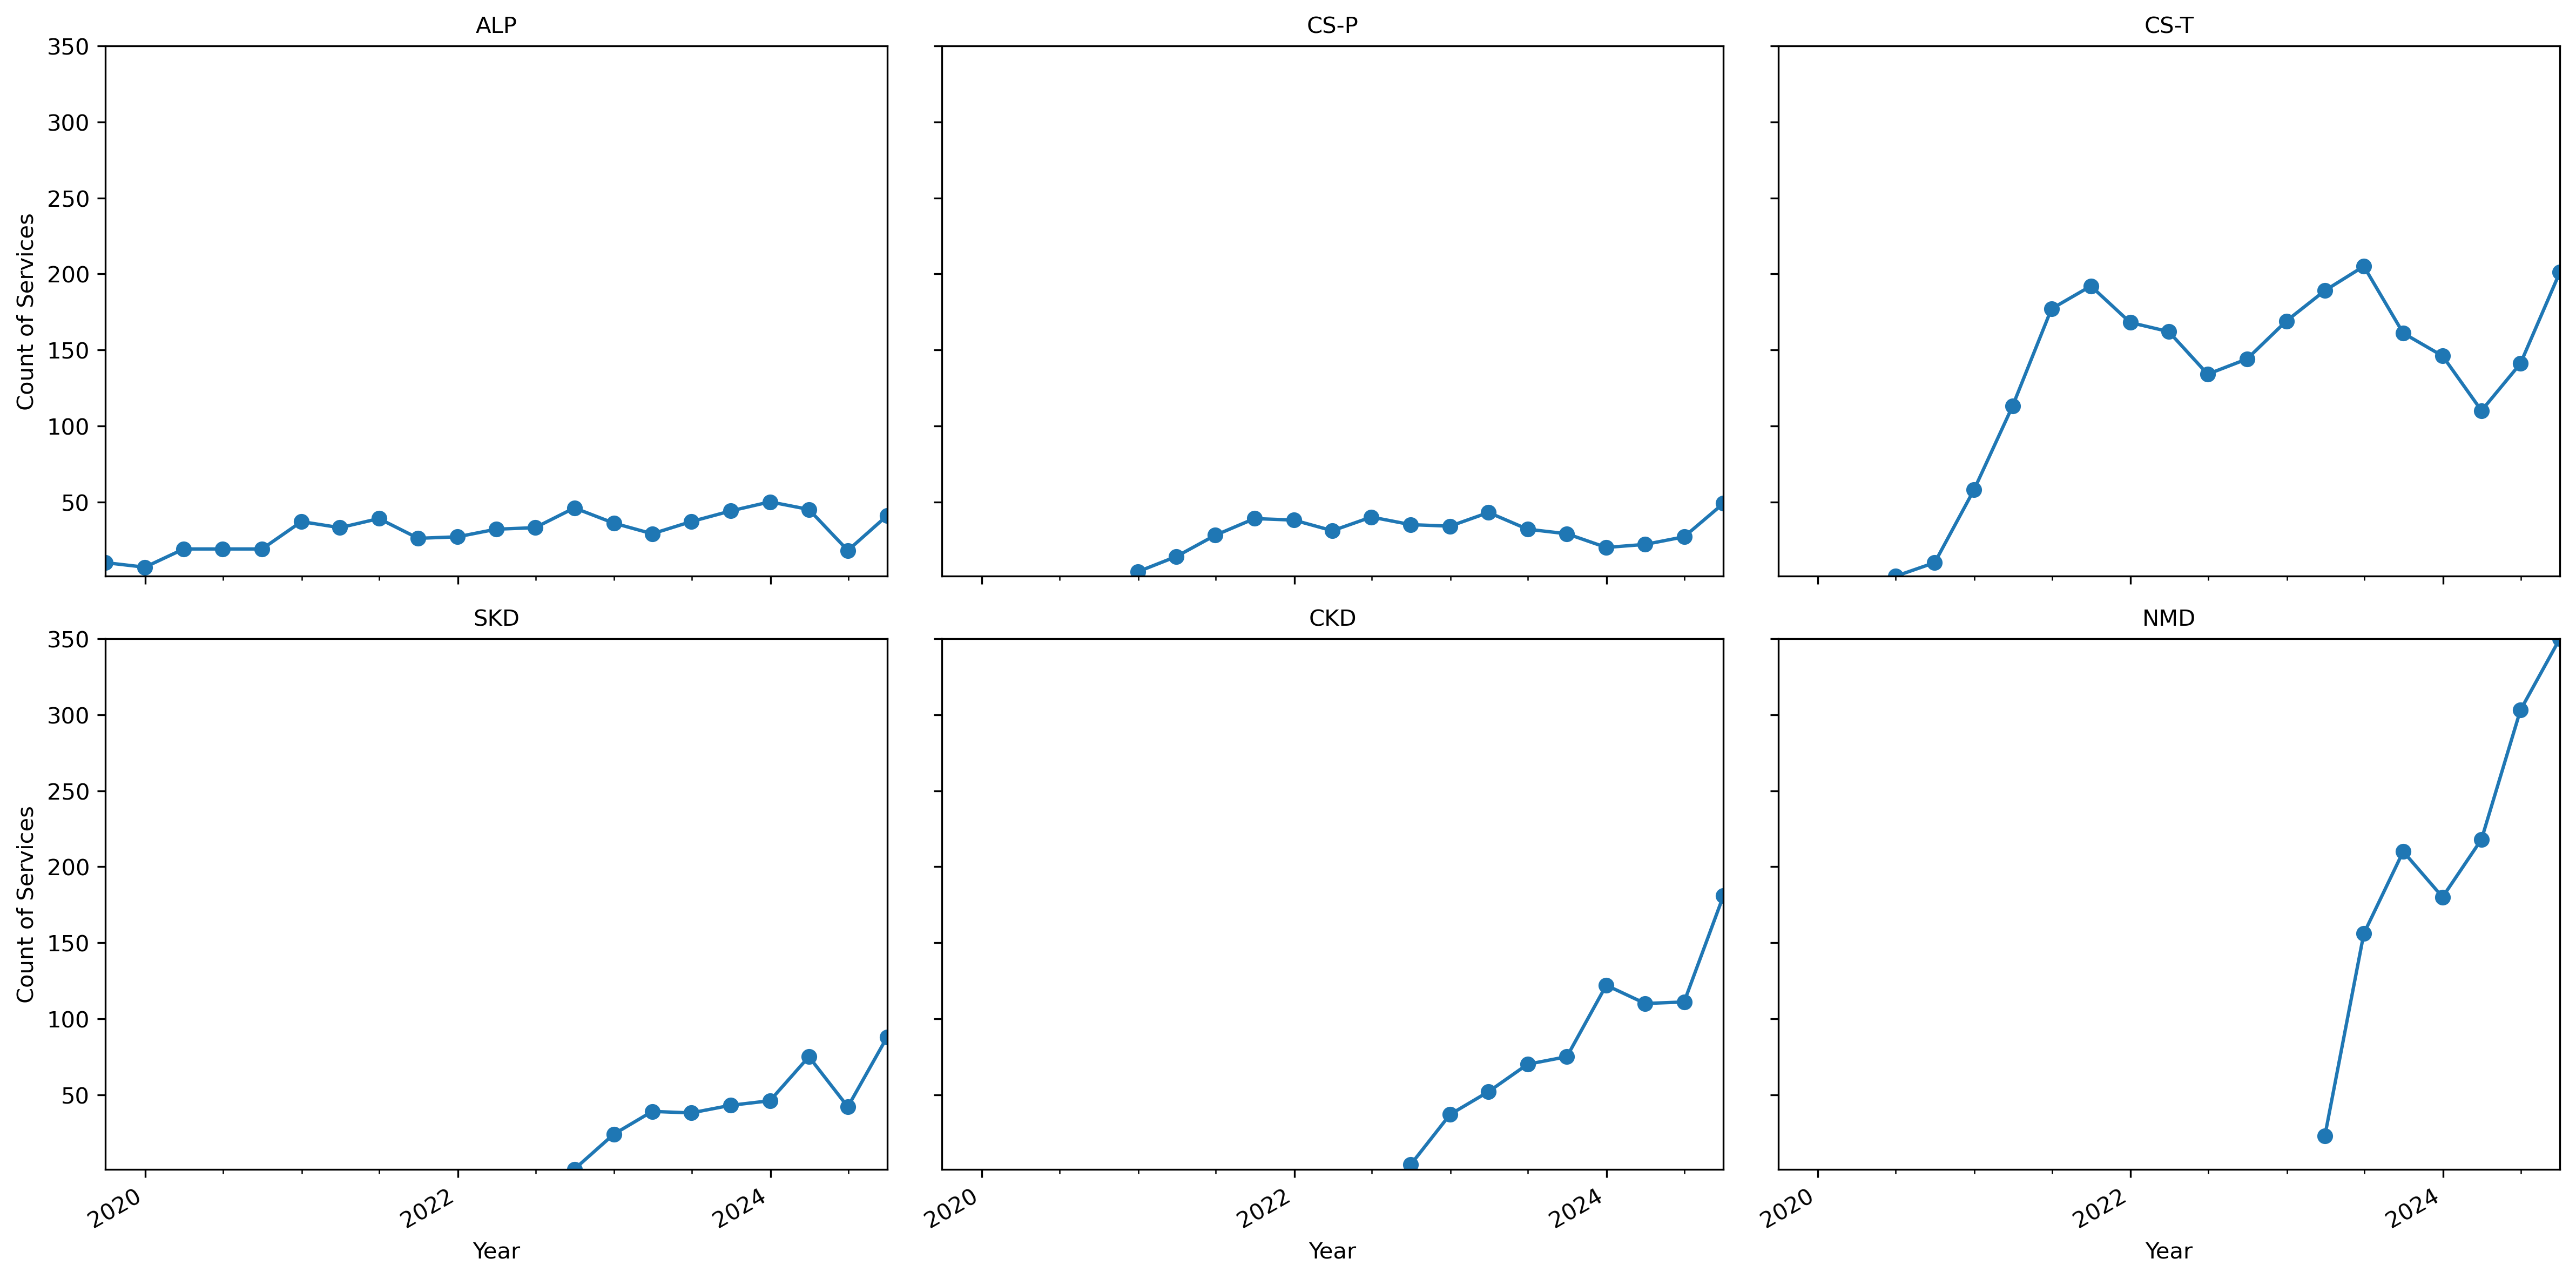

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Identify primary and secondary items
primary_items = ['73287', '73289', '73292', '73300']
secondary_items = [item for item in items_to_include if item not in primary_items]

# Aggregate 'Value' by quarter for each item
grouped_data = filtered_data.groupby('Item')['Value'].resample('QE').sum()

# Filter for items that exist in the grouped data
available_primary_items = [item for item in primary_items if item in grouped_data.index.get_level_values('Item')]
available_secondary_items = [item for item in secondary_items if item in grouped_data.index.get_level_values('Item')]

# Define a dictionary to map item IDs to custom titles.
# For example, rename '73300' to 'FMR1'
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD',   
    # Add more mappings if needed.
}

# Function to create subplots for a given set of items with optional custom titles.
# Added parameter 'major_tick_interval' to control the spacing of x-axis labels.
def create_subplots(items, x_range=None, filename=None, title_mapping=None, major_tick_interval=5):
    num_items = len(items)
    cols = 3  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300, sharex=True, sharey=True)
    axes = axes.flatten() if num_items > 1 else [axes]  # Flatten axes for easy iteration

    # Determine overall y-axis limits for consistency
    y_min, y_max = grouped_data.loc[items].min(), grouped_data.loc[items].max()

    for ax, item in zip(axes, items):
        item_data = grouped_data.loc[item]
        # Use custom title if provided, else default to "Item {item}"
        title = title_mapping.get(item, f'Item {item}') if title_mapping is not None else f'Item {item}'
        ax.plot(item_data.index, item_data, marker='o', linestyle='-', label=title)
        if x_range:
            ax.set_xlim(x_range)
        ax.set_ylim(y_min, y_max)
        ax.set_title(title, fontsize=10)

    # Hide unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Configure x-axis and y-axis labels
    for ax in axes[-cols:]:  # Last row
        ax.set_xlabel('Year', fontsize=10)
    for ax in axes[::cols]:  # First column
        ax.set_ylabel('Count of Services', fontsize=10)

    # Configure x-axis ticks using the provided major_tick_interval.
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(base=major_tick_interval))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Improve layout
    fig.autofmt_xdate()
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the figure if a filename is provided
    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Determine x-axis ranges for each plot
primary_x_range = (
    grouped_data.loc[available_primary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_primary_items].index.get_level_values('Month').max(),
)

secondary_x_range = (
    grouped_data.loc[available_secondary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_secondary_items].index.get_level_values('Month').max(),
)

# Create plots for primary and secondary items, passing the custom_titles mapping.
# For the primary axis items we use a 5-year interval, but for the secondary items we use a 2-year interval.
create_subplots(
    available_primary_items,
    x_range=primary_x_range,
    filename="PrimaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=5  # Fewer ticks, as the data spans a wider range
)

create_subplots(
    available_secondary_items,
    x_range=secondary_x_range,
    filename="SecondaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=2  # More ticks, to better match the data's range
)


### Utilisation, By Test, Monthly

/tmp/ipykernel_1861/608598251.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_items)


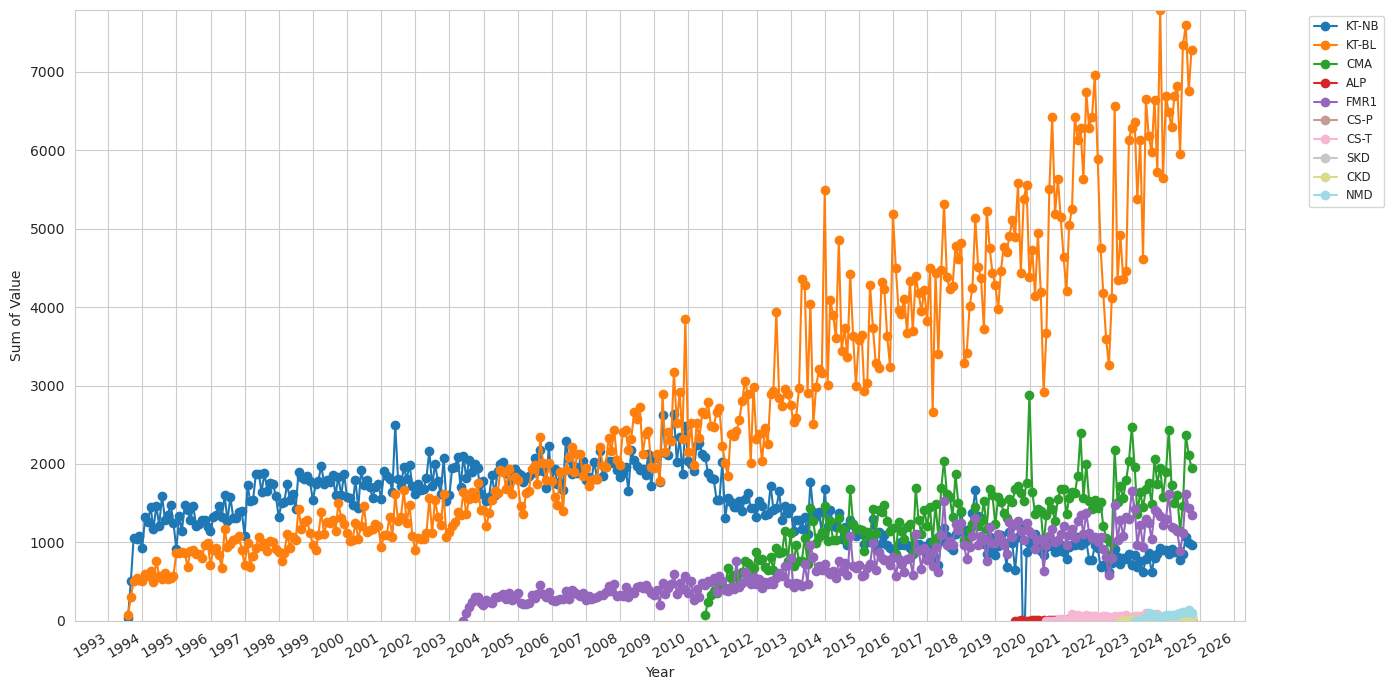

Plot saved as: MonthlySum_SelectedItems.svg


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Calculate the global y-axis maximum based on the highest peak after resampling
y_max = filtered_data.groupby('Item')['Value'].resample('ME').sum().max()
y_min = 0  # Assuming y-axis starts at 0 for better comparison

# Create a figure for plotting
plt.figure(figsize=(14, 7))

# Create a colormap with distinct colours (using 'tab20' for up to 20 distinct colours)
num_items = len(items_to_include)
colors = plt.cm.get_cmap('tab20', num_items)

# Plot each item using its custom label (if defined) and assign a distinct colour
for idx, item in enumerate(items_to_include):
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum()
    # Use the custom title if available; otherwise, default to "Item: {item}"
    label = custom_titles.get(item, f'Item: {item}')
    plt.plot(item_data.index, item_data, marker='o', linestyle='-', color=colors(idx), label=label)

# Set axis labels and limits
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim([y_min, y_max])

# Set x-axis major locator to every year and minor locator to every quarter
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve the display of x-axis labels
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)

# Display the plot
plt.show()

print(f"Plot saved as: {output_file}")


### Utilisation, Grouped, Monthly

/tmp/ipykernel_1861/4003599042.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Item'] = filtered_data['Item'].apply(


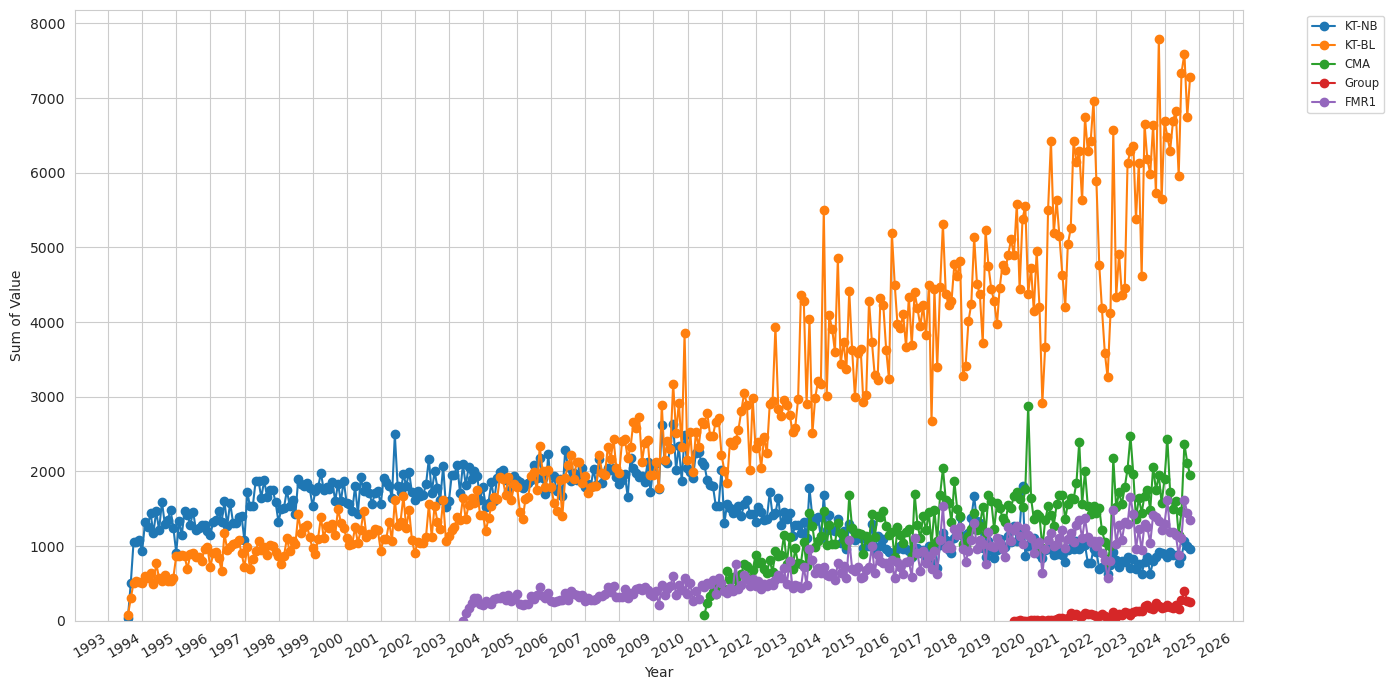

Plot saved as: MonthlySum_GroupedItems.svg


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Convert the "Value" column to absolute values
data['Value'] = data['Value'].abs()

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

# For the purpose of the plot we wish to display only a select few items individually.
# Items not in the list below will be grouped under "Group".
items_to_keep = ['73287', '73289', '73292', '73300']

# Update the "Item" column: use the custom title for items to keep and set the others to "Group".
filtered_data['Item'] = filtered_data['Item'].apply(
    lambda x: custom_titles[x] if x in items_to_keep else 'Group'
)

# Plotting all items (and the group) on the same plot
plt.figure(figsize=(14, 7))

# Loop through each unique item label in the filtered data
for item in filtered_data['Item'].unique():
    # Resample by month-end and sum the "Value" column
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum()
    plt.plot(item_data.index, item_data, marker='o', linestyle='-', label=item)

# Set labels and format the x-axis
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim(bottom=0)

# Major ticks every year; minor ticks at January, April, July, October
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()  # Auto-format date labels

# Place legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()

# Save the figure as an SVG file
output_file = "MonthlySum_GroupedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)
plt.show()

print(f"Plot saved as: {output_file}")


### Utilisation, Pred vs Actual

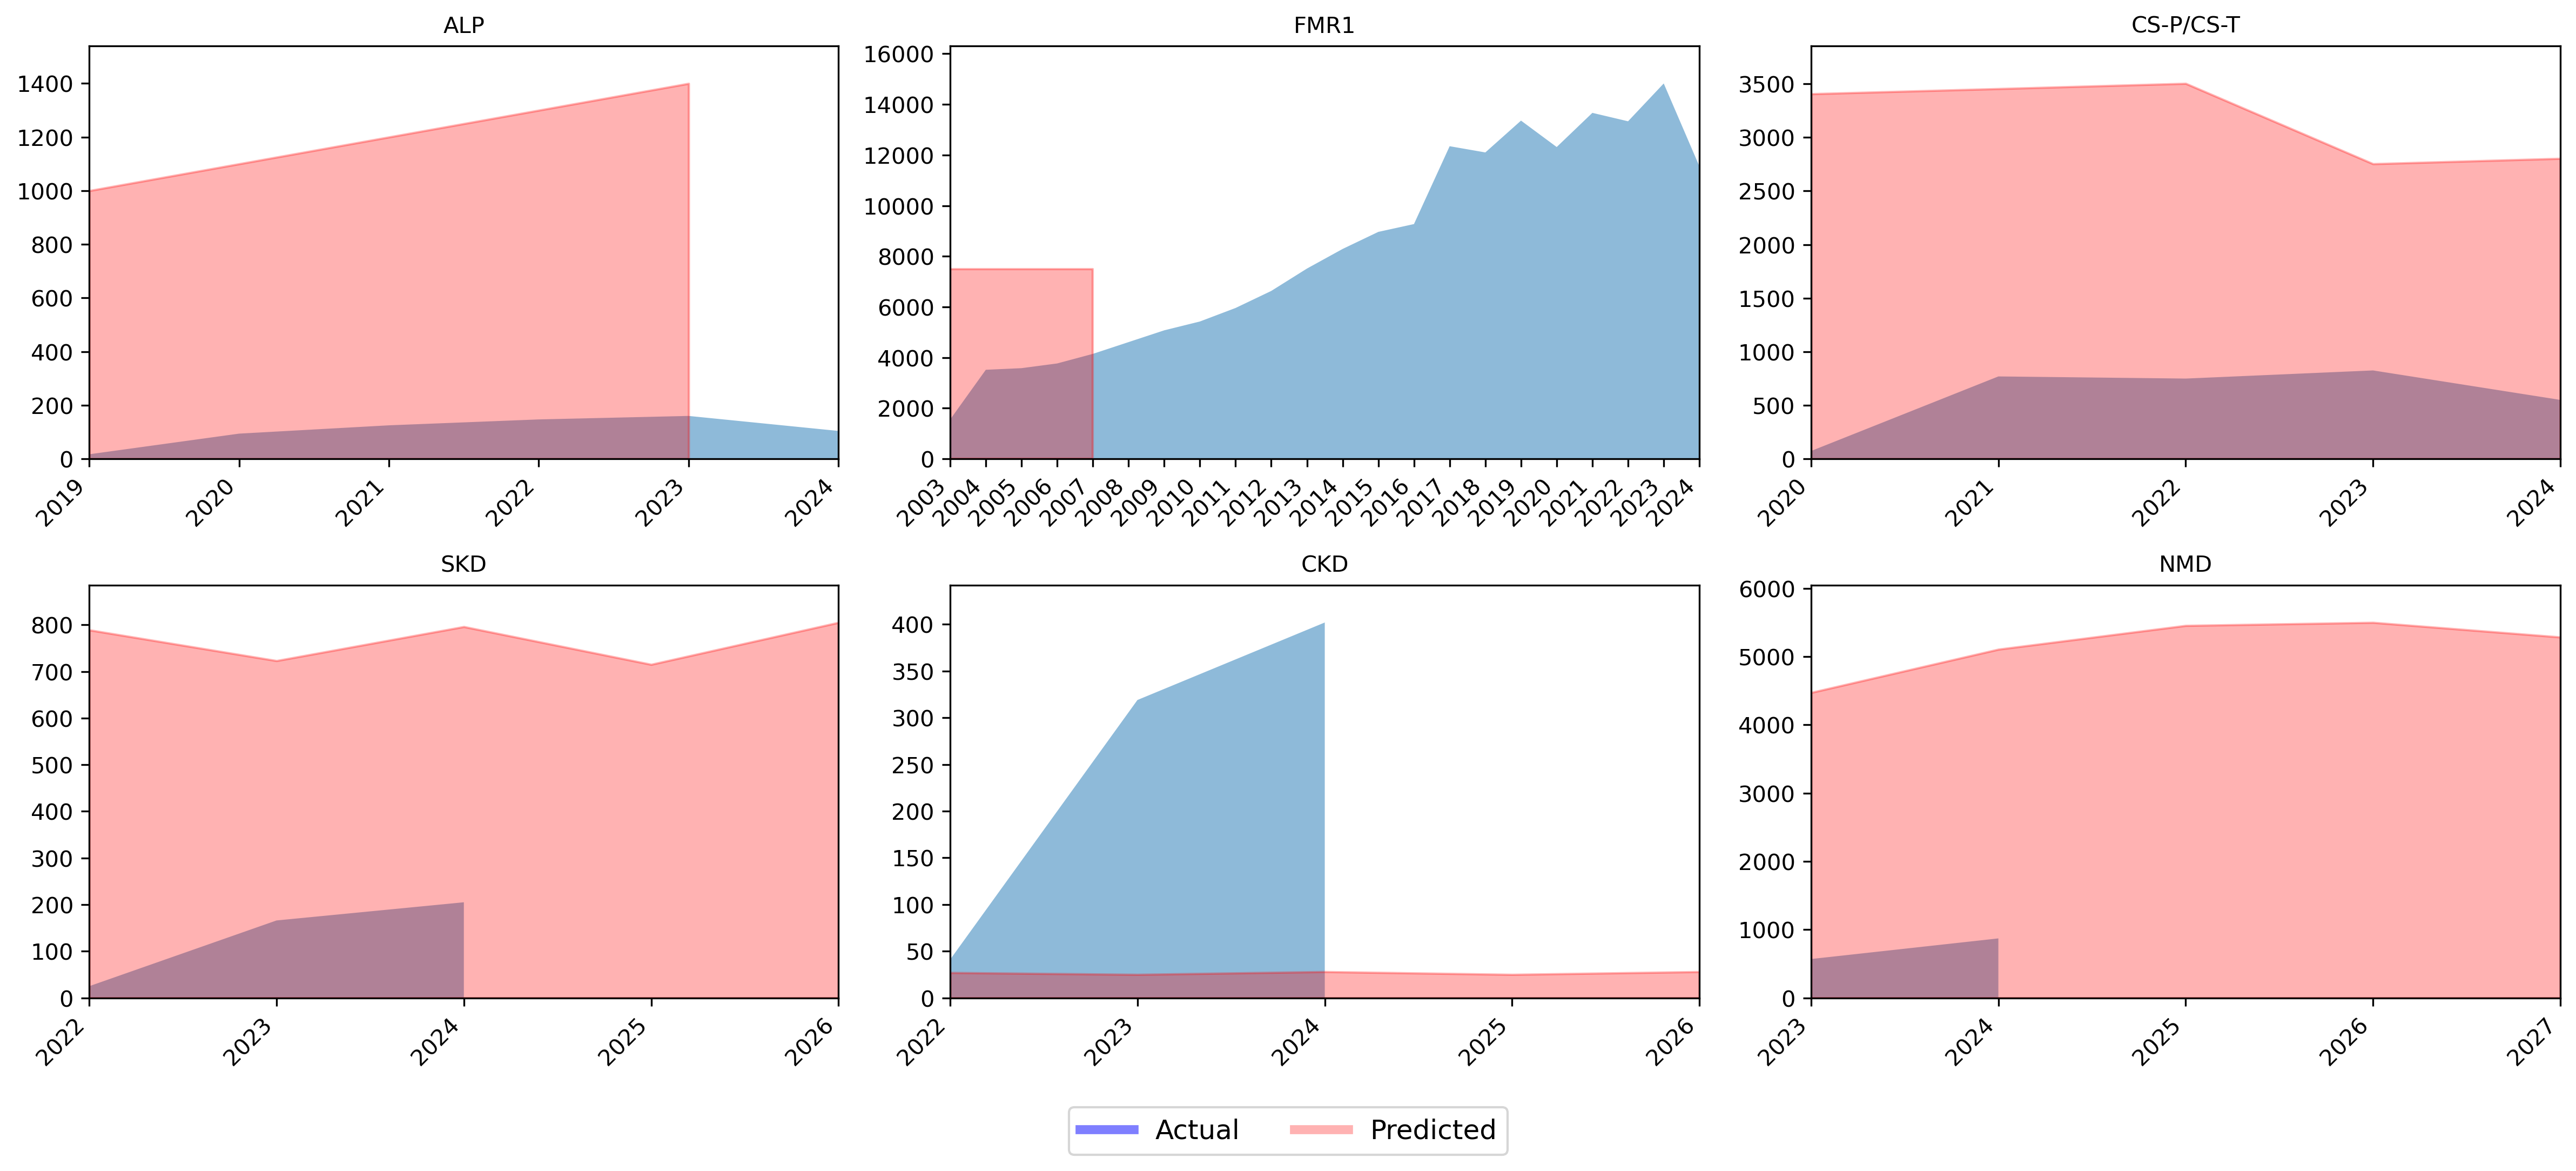

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73300', '73358', '73359', '73360', '73395', '73298', '73299', '73401',
    '73402', '73422', '73425', '73426', '73442', '73456', '73457', '73458'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Combine 73358 and 73359 into a single item '73358_73359'
filtered_data.loc[:, 'Item'] = filtered_data['Item'].replace({'73359': '73358_73359', '73358': '73358_73359'})

# Re-aggregate 'Value' by year for each item
grouped_data = filtered_data.groupby(['Item', filtered_data.index.year])['Value'].sum()

# Ensure the combined item '73358_73359' is included in available_items
available_items = grouped_data.index.get_level_values('Item').unique().tolist()

# Predicted values (annual)
predicted_values = {
    '73300': [7500, 7500, 7500, 7500, 7500],
    '73358_73359': [3406, 3454, 3503, 2753, 2803],
    '73398': [2300, 1170, 1190, 1210, 1230],
    '73401': [789, 723, 796, 715, 805],
    '73402': [27, 25, 28, 25, 28],
    '73422': [4472, 5106, 5454, 5499, 5285],
    '73298': [1000, 1100, 1200, 1300, 1400]  # Example values; replace with actual predictions
}

# Custom titles mapping for items
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

def get_custom_title(item):
    """
    Return a custom title for an item code.
    If the item code is a combination (e.g., '73358_73359'),
    then return a concatenated custom title for each part.
    """
    if "_" in item:
        parts = item.split("_")
        # Look up each part in custom_titles; if not found, use the original code
        mapped_parts = [custom_titles.get(part, part) for part in parts]
        return "/".join(mapped_parts)
    else:
        return custom_titles.get(item, item)

# Function to create subplots for a given set of items
def create_subplots(items, filename=None):
    num_items = len(items)
    cols = 3  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300)
    axes = axes.flatten() if num_items > 1 else [axes]  # Flatten axes for easy iteration

    for ax, item in zip(axes, items):
        max_y = 0

        # Plot actual data if available
        if item in grouped_data.index.get_level_values('Item'):
            item_data = grouped_data.loc[item]
            ax.fill_between(item_data.index, item_data, alpha=0.5, label="Actual")
            max_y = max(max_y, item_data.max())
        else:
            # Initialize an empty series if no actual data exists
            item_data = pd.Series()

        # Plot predicted values if available
        if item in predicted_values:
            # Determine the start year using actual data if available, otherwise use a default
            if not item_data.empty:
                start_year = item_data.index.min()
            else:
                start_year = pd.Timestamp.now().year - len(predicted_values[item]) + 1

            pred_years = list(range(start_year, start_year + len(predicted_values[item])))
            pred_values = predicted_values[item]
            ax.fill_between(pred_years, pred_values, alpha=0.3, color='red', label="Predicted")
            max_y = max(max_y, max(pred_values))

        # Apply y-axis limits with some padding
        ax.set_ylim(0, max_y * 1.1)

        # Compute x-axis ticks as the union of actual and predicted years
        x_ticks = set()
        if not item_data.empty:
            x_ticks.update(item_data.index)
        if item in predicted_values:
            # Ensure that we have a proper starting year (an integer) for predicted data
            if not item_data.empty:
                start_year = item_data.index.min()
            else:
                start_year = pd.Timestamp.now().year - len(predicted_values[item]) + 1
            predicted_years = list(range(start_year, start_year + len(predicted_values[item])))
            x_ticks.update(predicted_years)

        x_ticks = sorted(x_ticks)
        if x_ticks:
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=45, ha='right')
            ax.set_xlim(min(x_ticks), max(x_ticks))

        # Set the subplot title using the custom title mapping
        ax.set_title(get_custom_title(item), fontsize=10)

    # Hide unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Add a single legend for the entire figure with automatic positioning
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.5, label='Actual'),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Predicted')
    ]
    fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.1))

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # Display the plot
    plt.show()

    # Save the figure if a filename is provided
    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Create plots for available items
create_subplots(
    available_items,
    filename="FilteredItems_3cols.svg"
)


### Diffussion Innovation Predictions, By Group

/tmp/ipykernel_1861/4108562910.py:78: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/4108562910.py:51: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/4108562910.py:51: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/4108562910.py:48: RuntimeWarning: overflow encountered in exp
  return K / (1 + np.exp(-r * (t - t0)))
/tmp/ipykernel_1861/4108562910.py:54: RuntimeWarning: overflow encountered in exp
  return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
/tmp/ipykernel_1861/4108562910.py:54: RuntimeWarning: invalid value encountered in divide
  return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
/tmp/ipykernel_1861/4108562910.py:54: RuntimeWarning: overflow encountered in multiply
  return M * (1 - np.exp(-(p 

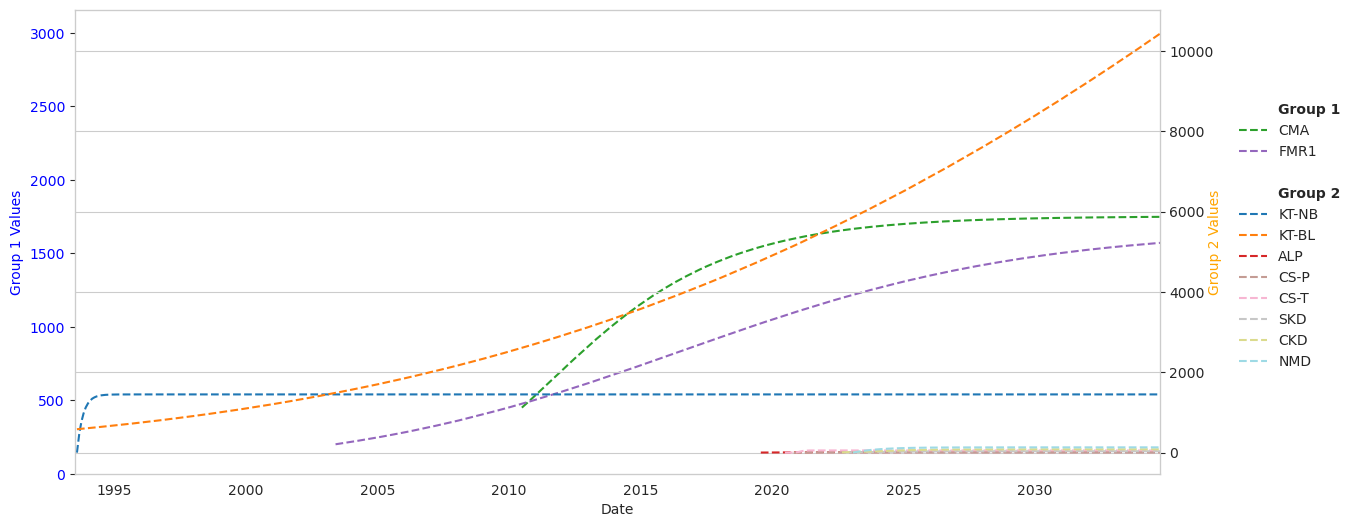

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D  # For creating dummy legend handles

# Custom titles mapping for items
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Prediction range
prediction_end = pd.Timestamp('2034-09-30')

# Separate items into two groups.
# Ensure that '73300' is in Group 1 (with '73292') and not in Group 2.
group1 = ['73292', '73300']
group2 = [item for item in valid_items if item not in group1]

# Determine common x-axis range.
common_x_start = filtered_data.index.min()

# Compute y-axis range from both historical and model-predicted data.
def calculate_future_range(data, models):
    all_values = data['Value'].tolist()
    for item in valid_items:
        item_data = data[data['Item'] == item]['Value'].resample('ME').sum().dropna()
        if not item_data.empty:
            time_index = np.arange(len(item_data))
            prediction_index = np.arange(len(item_data) + (prediction_end - item_data.index[-1]).days // 30 + 1)
            for model_name, model_func in models.items():
                try:
                    # Basic initial guess for range estimation
                    params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
                    future_predicted = model_func(prediction_index, *params)
                    all_values.extend(future_predicted)
                except Exception:
                    continue
    return min(all_values), max(all_values)

models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}
common_y_min, common_y_max = calculate_future_range(filtered_data, models)

# Plot settings
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(valid_items)))
color_mapping = dict(zip(valid_items, colors))

# Storage for legend handles, separated by group.
legend_handles_group1 = []
legend_handles_group2 = []

# Iterate through each group and fit models with optimized initial guesses and bounds.
for group, axis in [(group1, ax), (group2, ax.twinx())]:
    for item in group:
        item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
        if item_data.empty:
            print(f"Item {item} has no data after resampling. Skipping.")
            continue

        # Create a time index based on the length of the data.
        time_index = np.arange(len(item_data))
        prediction_index = np.arange(len(item_data) + (prediction_end - item_data.index[-1]).days // 30 + 1)

        # Compute basic heuristics from the data for initial guesses.
        y_max = item_data.max()
        t_mid = len(item_data) / 2

        best_model_name = None
        best_model_metrics = {'r2': -np.inf}  # Initialize with worst r2 value.
        best_model_predicted = None

        for model_name, model_func in models.items():
            try:
                # Set initial guesses (p0) and bounds based on the model.
                if model_name == "Logistic Diffusion":
                    p0 = [y_max * 1.5, 0.1, t_mid]
                    bounds = ([0, 0, 0], [y_max * 10, 1, len(item_data)])
                elif model_name == "Gompertz":
                    p0 = [y_max, 1, 0.1]
                    bounds = ([0, 0, 0], [y_max * 10, 10, 1])
                elif model_name == "Bass Diffusion":
                    p0 = [0.03, 0.38, y_max * 1.5]
                    bounds = ([0, 0, 0], [1, 1, y_max * 10])
                else:
                    p0 = None
                    bounds = (-np.inf, np.inf)

                params, _ = curve_fit(
                    model_func, time_index, item_data,
                    p0=p0, bounds=bounds, maxfev=10000
                )
                predicted = model_func(time_index, *params)
                future_predicted = model_func(prediction_index, *params)
                r2 = r2_score(item_data, predicted)

                if r2 > best_model_metrics['r2']:
                    best_model_name = model_name
                    best_model_metrics = {'r2': r2}
                    best_model_predicted = future_predicted

            except Exception as e:
                print(f"Error fitting {model_name} for item {item}: {e}")

        # Only plot if a best model was successfully fit.
        if best_model_predicted is not None:
            axis.plot(
                pd.date_range(start=item_data.index[0], periods=len(prediction_index), freq='ME'),
                best_model_predicted,
                label=f'{custom_titles.get(item, item)} Best Model: {best_model_name}',
                linestyle='--', color=color_mapping[item]
            )
            # Create a legend handle with the custom title.
            handle = Line2D([], [], color=color_mapping[item], linestyle='--', 
                            label=custom_titles.get(item, item))
            if group == group1:
                legend_handles_group1.append(handle)
            else:
                legend_handles_group2.append(handle)

# Set common x-axis limits and force y-axis lower limit to 0.
ax.set_xlim([common_x_start, prediction_end])
ax.set_ylim([0, common_y_max])
ax.set_xlabel('Date')
ax.set_ylabel('Group 1 Values', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax2 = ax.twinx()
ax2.set_ylim([0, common_y_max])
ax2.set_ylabel('Group 2 Values', color='orange', labelpad=35)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_ticks([])  # Optionally remove secondary axis tick labels

# Remove gridlines.
ax.grid(False, which='both')
ax2.grid(False, which='both')

#######################################
# Create a single combined legend with group headers.
#######################################
# Create dummy header handles (they will appear with only text)
dummy_header1 = Line2D([], [], color='none', label='Group 1')
dummy_header2 = Line2D([], [], color='none', label='Group 2')
dummy_spacer = Line2D([], [], color='none', label='')  # Blank spacer

combined_handles = [dummy_header1] + legend_handles_group1 + [dummy_spacer, dummy_header2] + legend_handles_group2

# Create a single legend (vertical list) and place it below the axes.
# Shift the legend to the right by using an x-value of 0.8 in bbox_to_anchor.
legend = ax.legend(handles=combined_handles, loc='lower center',
                   bbox_to_anchor=(1.12, 0.2
                                  ), ncol=1, frameon=False)

# Optionally, adjust the text properties for dummy headers.
for text in legend.get_texts():
    label = text.get_text()
    if label in ['Group 1', 'Group 2']:
        text.set_fontweight('bold')

# Adjust layout to make room for the legend below the plot.
plt.subplots_adjust(bottom=0.3)
plt.show()


### Diffusion Innovation Curves, By Item

/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

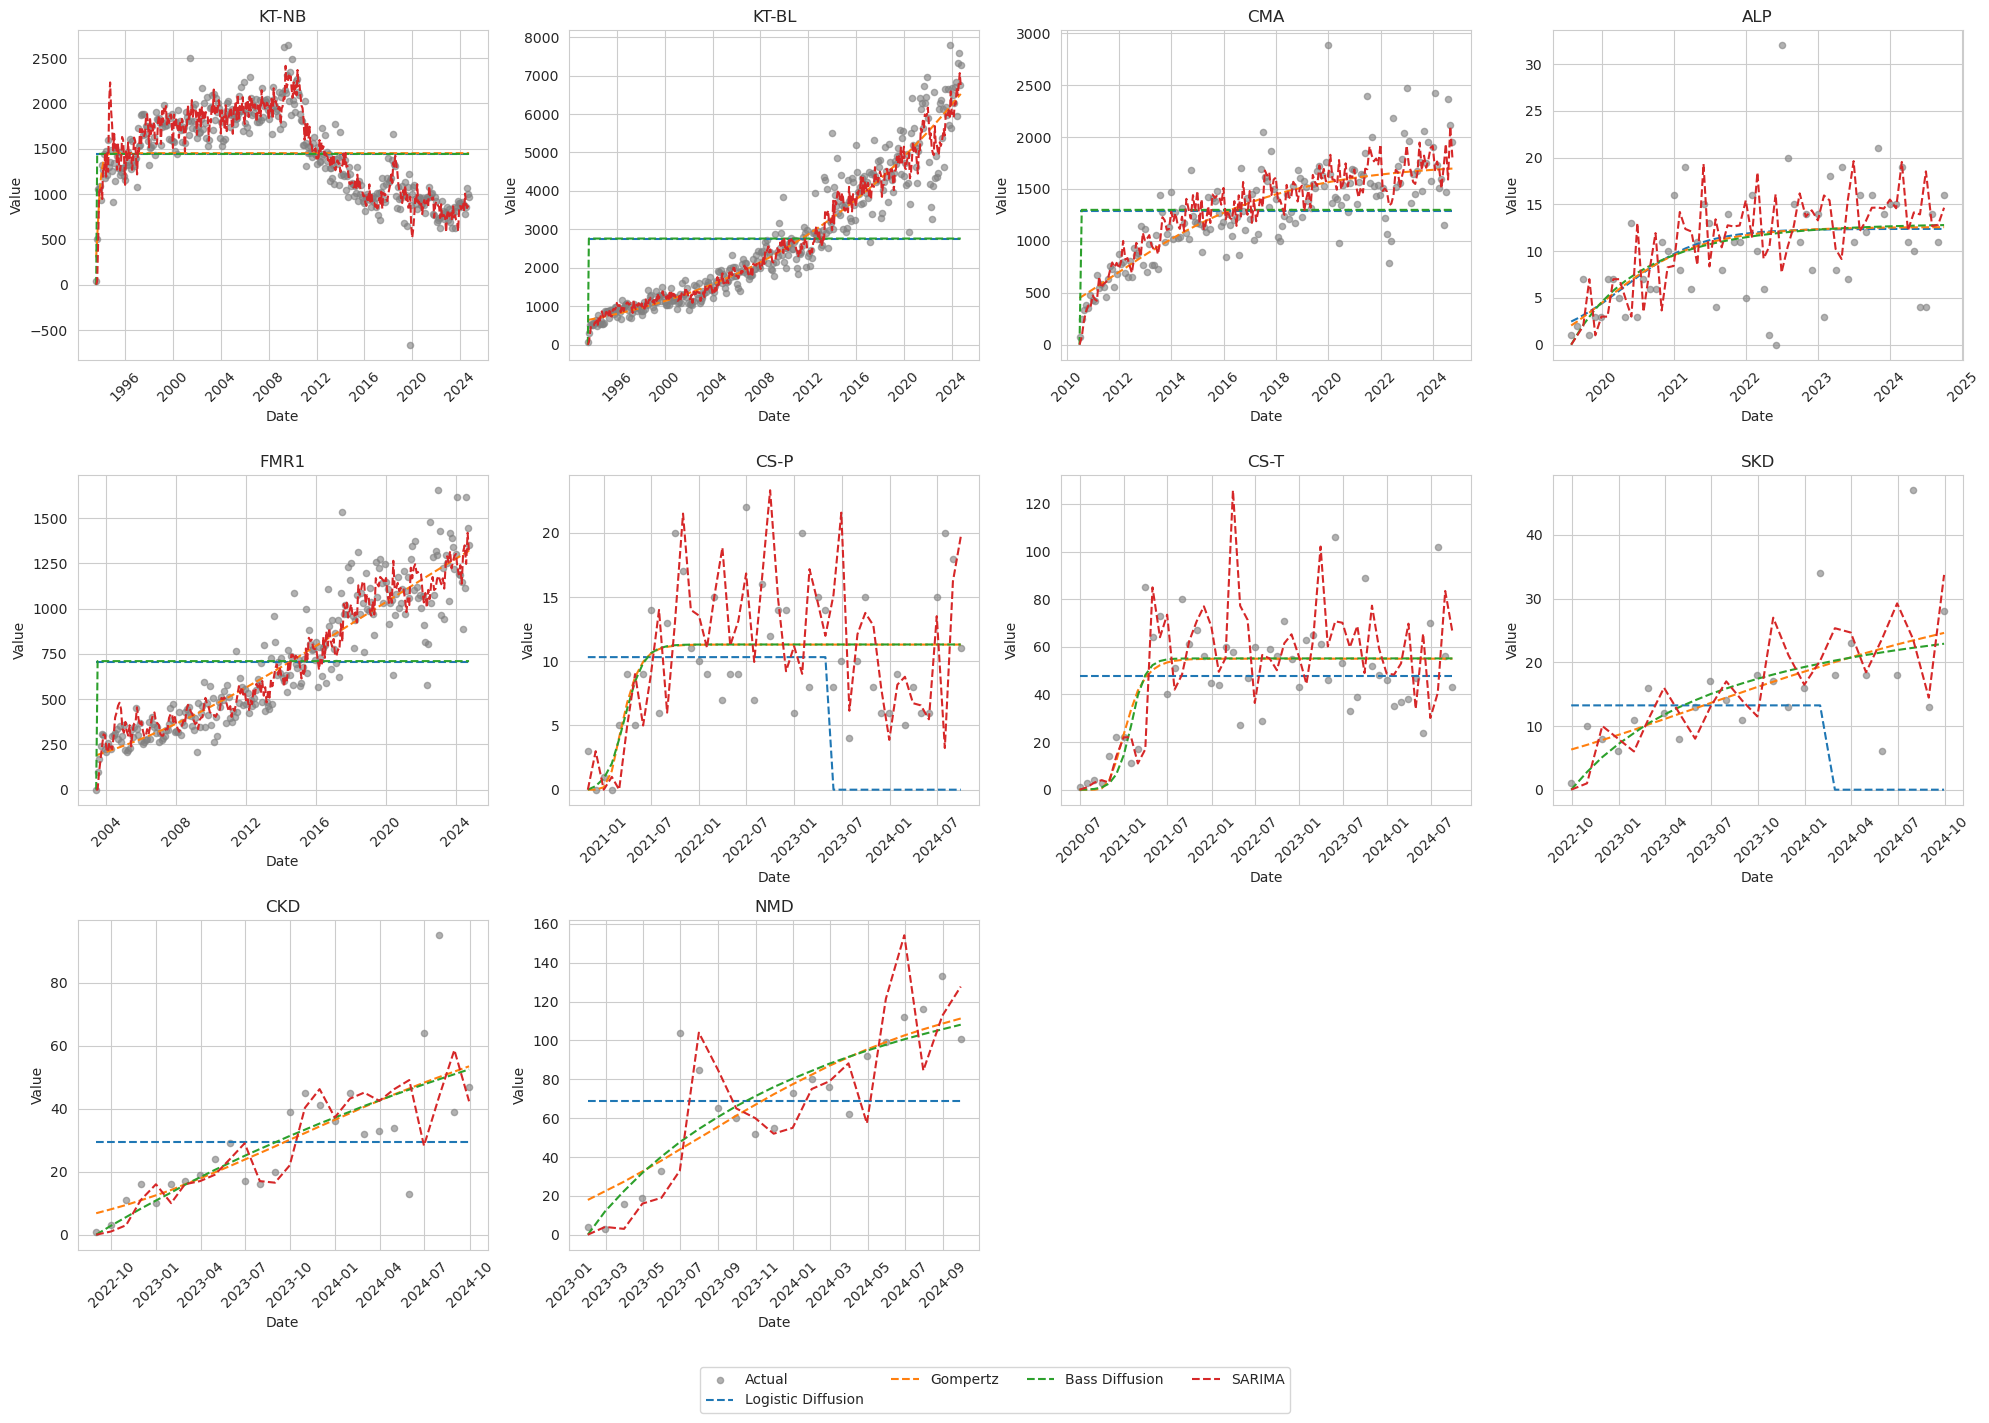

     Item               Model     r2      MAE      MAPE
0   73287  Logistic Diffusion  -0.00   392.81      0.42
1   73287            Gompertz   0.04   384.14      0.33
2   73287      Bass Diffusion   0.02   389.13      0.32
3   73287              SARIMA   0.78   156.11      0.12
4   73289  Logistic Diffusion   0.00  1482.62      0.96
5   73289            Gompertz   0.91   343.10      0.15
6   73289      Bass Diffusion   0.01  1476.99      0.87
7   73289              SARIMA   0.92   328.11      0.13
8   73292  Logistic Diffusion   0.00   365.81      0.48
9   73292            Gompertz   0.64   197.30      0.19
10  73292      Bass Diffusion   0.04   359.14      0.39
11  73292              SARIMA   0.65   200.68      0.17
12  73298  Logistic Diffusion   0.25     3.98  8.68e+14
13  73298            Gompertz   0.25     3.97  8.62e+14
14  73298      Bass Diffusion   0.25     3.98  8.51e+14
15  73298              SARIMA  -0.22     4.96  1.15e+15
16  73300  Logistic Diffusion   0.00   319.17   

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize list for storing results
model_results = []

# Plot settings: create a grid of subplots
n_items = len(valid_items)
cols = 4
rows = int(np.ceil(n_items / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

# Iterate through each item and fit models
for i, item in enumerate(valid_items):
    # Use the custom mapping if available
    display_name = custom_titles.get(item, item)
    
    # Resample data by month end (using 'ME' frequency)
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()

    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue

    time_index = np.arange(len(item_data))
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }

    results = {}

    for model_name, model_func in models.items():
        try:
            # For the Gompertz model, supply initial guesses and bounds.
            if model_name == "Gompertz":
                p0 = [max(item_data), 1, 0.1]  # Initial guesses: asymptote, and two positive parameters
                params, _ = curve_fit(model_func, time_index, item_data,
                                      p0=p0, bounds=(0, [np.inf, np.inf, np.inf]),
                                      maxfev=10000)
            else:
                params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)

            predicted = model_func(time_index, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)

            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)

        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")

    # Store the model metrics for later inspection
    for model_name, metrics in results.items():
        model_results.append({
            'Item': item,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })

    # Plot the actual vs predicted values
    ax = axes[i]
    # Now using only the model type for the legend labels:
    ax.scatter(item_data.index, item_data, label='Actual',
               color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(item_data.index, metrics['predicted'],
                label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ---- Build a global legend using only model types ----
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))
# -----------------------------------------------------------------------

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to DataFrame and format values
results_df = pd.DataFrame(model_results)

# Format values for display
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(lambda x: f"{x:.2e}" if x >= 100000 else f"{x:.2f}")

print(results_df)


/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

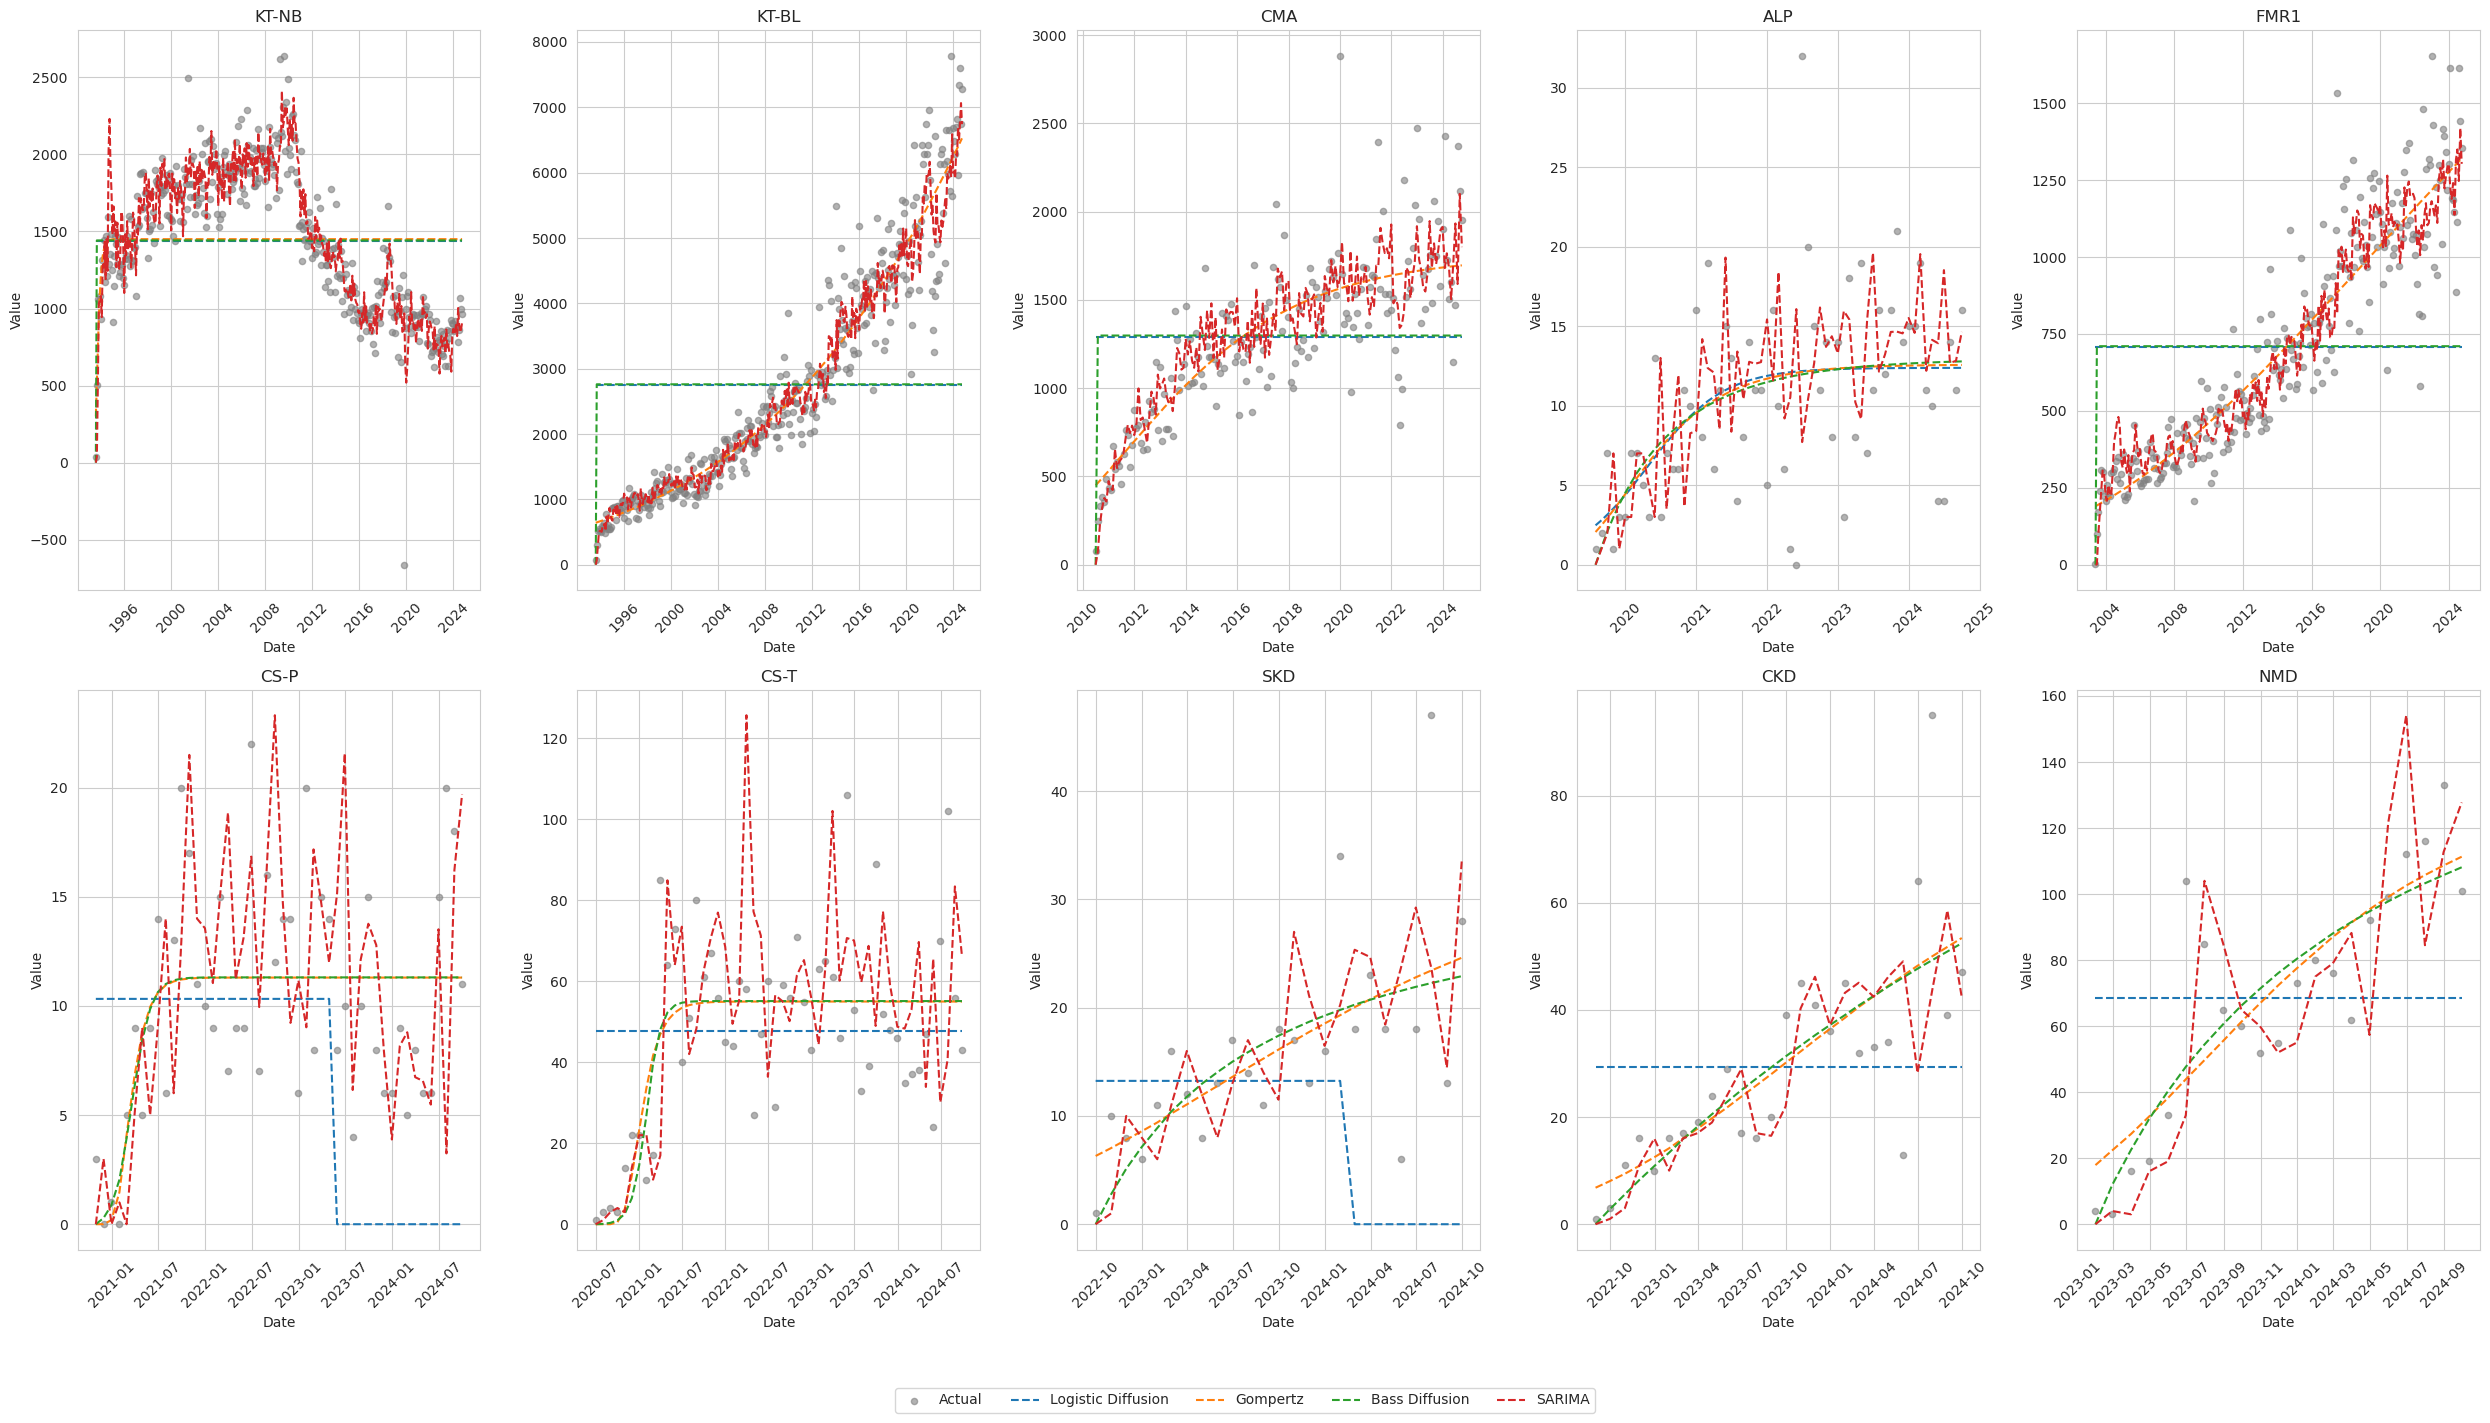

     Item               Model     r2      MAE      MAPE
0   73287  Logistic Diffusion  -0.00   392.81      0.42
1   73287            Gompertz   0.04   384.14      0.33
2   73287      Bass Diffusion   0.02   389.13      0.32
3   73287              SARIMA   0.78   156.11      0.12
4   73289  Logistic Diffusion   0.00  1482.62      0.96
5   73289            Gompertz   0.91   343.10      0.15
6   73289      Bass Diffusion   0.01  1476.99      0.87
7   73289              SARIMA   0.92   328.11      0.13
8   73292  Logistic Diffusion   0.00   365.81      0.48
9   73292            Gompertz   0.64   197.30      0.19
10  73292      Bass Diffusion   0.04   359.14      0.39
11  73292              SARIMA   0.65   200.68      0.17
12  73298  Logistic Diffusion   0.25     3.98  8.68e+14
13  73298            Gompertz   0.25     3.97  8.62e+14
14  73298      Bass Diffusion   0.25     3.98  8.51e+14
15  73298              SARIMA  -0.22     4.96  1.15e+15
16  73300  Logistic Diffusion   0.00   319.17   

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize list for storing results
model_results = []

# Plot settings: create a grid of subplots with 5 columns
n_items = len(valid_items)
cols = 5
rows = int(np.ceil(n_items / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 15))  # Increased width for 5 columns
axes = axes.flatten()

# Iterate through each item and fit models
for i, item in enumerate(valid_items):
    # Use the custom mapping if available
    display_name = custom_titles.get(item, item)
    
    # Resample data by month end (using 'ME' frequency)
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()

    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue

    time_index = np.arange(len(item_data))
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }

    results = {}

    for model_name, model_func in models.items():
        try:
            # For the Gompertz model, supply initial guesses and bounds.
            if model_name == "Gompertz":
                p0 = [max(item_data), 1, 0.1]  # Initial guesses: asymptote, and two positive parameters
                params, _ = curve_fit(model_func, time_index, item_data,
                                      p0=p0, bounds=(0, [np.inf, np.inf, np.inf]),
                                      maxfev=10000)
            else:
                params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)

            predicted = model_func(time_index, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)

            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)

        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")

    # Store the model metrics for later inspection
    for model_name, metrics in results.items():
        model_results.append({
            'Item': item,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })

    # Plot the actual vs predicted values
    ax = axes[i]
    # Use only the model type for the legend labels
    ax.scatter(item_data.index, item_data, label='Actual',
               color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(item_data.index, metrics['predicted'],
                label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ---- Build a global legend using only model types ----
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.05))
# -----------------------------------------------------------------------

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to DataFrame and format values
results_df = pd.DataFrame(model_results)

# Format values for display
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(lambda x: f"{x:.2e}" if x >= 100000 else f"{x:.2f}")

print(results_df)


### Scenario Analysis, by Group

/tmp/ipykernel_1861/4201869768.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


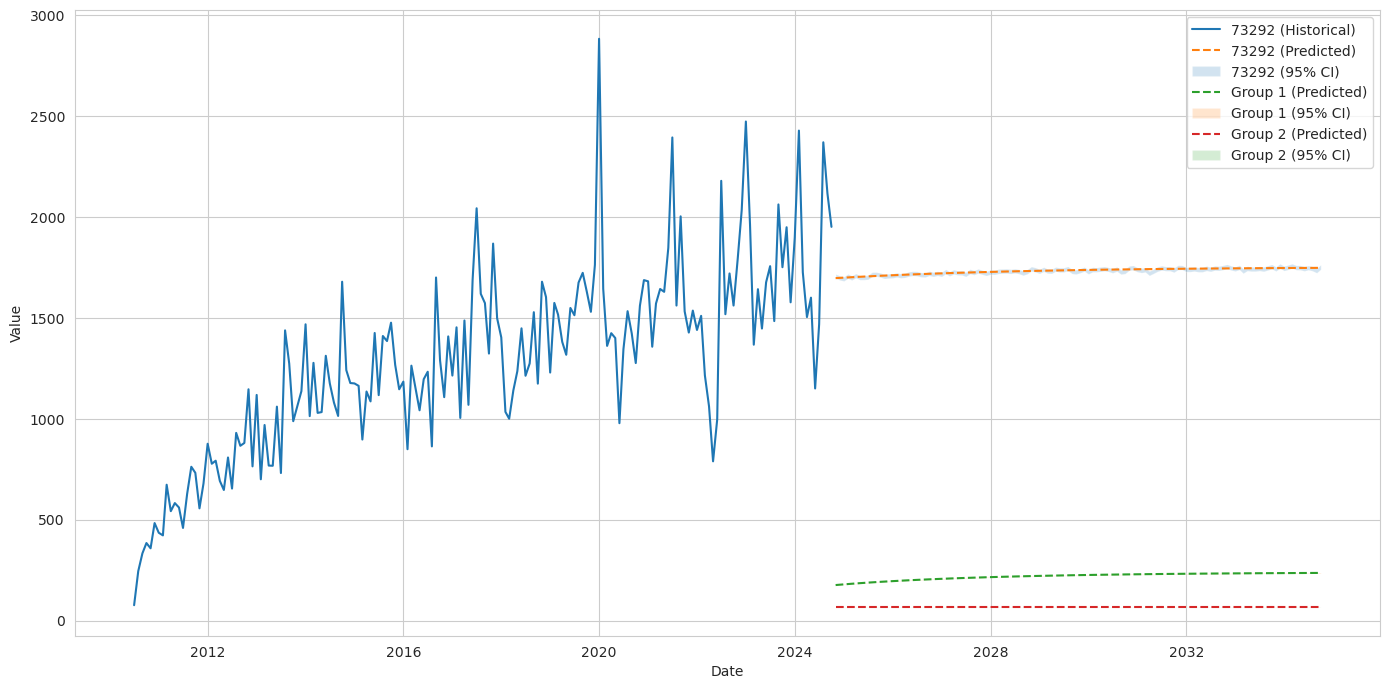

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73292', '73298', '73299', '73358', '73359',
    '73360', '73395', '73401', '73402', '73422',
    '73425', '73426', '73442', '73456', '73457', '73458'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Define the individual components of each group
group_1_items = [item for item in filtered_data['Item'].unique() if item not in ['73292', '73358', '73359']]
group_2_items = ['73358', '73359']

# Define model functions
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize containers
model_predictions = {}
confidence_intervals = {}
historical_data = {}

# Function to calculate bootstrapped CIs
def calculate_bootstrap_ci(data):
    ci = bs.bootstrap(data, stat_func=bs_stats.mean, alpha=0.05)
    return ci.lower_bound, ci.upper_bound

# Process each category
for category in ['73292'] + group_1_items + group_2_items:
    category_data = filtered_data[filtered_data['Item'] == category]['Value'].resample('ME').sum().dropna()

    if category_data.empty:
        print(f"No data found for '{category}'. Skipping...")
        continue

    # Save historical data
    historical_data[category] = category_data

    # Convert to NumPy array
    category_data = category_data.values

    # Create time indices
    current_time_index = np.arange(len(category_data))
    future_time_index = np.arange(len(category_data), len(category_data) + 120)

    try:
        # Fit models
        if category == '73292':
            params, _ = curve_fit(
                gompertz, current_time_index, category_data, maxfev=10000,
                bounds=(0, np.inf)
            )
            fitted_values = gompertz(current_time_index, *params)
            future_predicted = gompertz(future_time_index, *params)
        else:
            params, _ = curve_fit(
                bass_diffusion, current_time_index, category_data, maxfev=10000,
                bounds=(0, [1, 1, np.inf])
            )
            fitted_values = bass_diffusion(current_time_index, *params)
            future_predicted = bass_diffusion(future_time_index, *params)

        # Save predictions
        model_predictions[category] = future_predicted

        # Calculate confidence intervals
        ci_lower = []
        ci_upper = []
        for prediction in future_predicted:
            # Use a small range of values around each prediction for bootstrapping
            sample_data = np.random.normal(loc=prediction, scale=prediction * 0.1, size=1000)
            ci = calculate_bootstrap_ci(sample_data)
            ci_lower.append(ci[0])
            ci_upper.append(ci[1])
        confidence_intervals[category] = (np.array(ci_lower), np.array(ci_upper))

    except Exception as e:
        print(f"Error fitting model for '{category}': {e}")
        continue

# Aggregate group predictions
group_1_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_1_items], axis=0)
group_2_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_2_items], axis=0)

# Aggregate group CIs
group_1_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_1_items], axis=0)
group_1_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_1_items], axis=0)

group_2_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_2_items], axis=0)
group_2_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_2_items], axis=0)

# Save group predictions and CIs
model_predictions['Group 1'] = group_1_predictions
confidence_intervals['Group 1'] = (group_1_ci_lower, group_1_ci_upper)

model_predictions['Group 2'] = group_2_predictions
confidence_intervals['Group 2'] = (group_2_ci_lower, group_2_ci_upper)

# Create future index
future_index = pd.date_range(
    start=historical_data['73292'].index[-1] + pd.offsets.MonthEnd(1),
    periods=120,
    freq='M'
)

# Plotting
plt.figure(figsize=(14, 7))

# Plot 73292
if '73292' in model_predictions and '73292' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['73292']
    plt.plot(historical_data['73292'].index, historical_data['73292'], label='73292 (Historical)', linestyle='-')
    plt.plot(future_index, model_predictions['73292'], label='73292 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='73292 (95% CI)')

# Plot Group 1
if 'Group 1' in model_predictions and 'Group 1' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['Group 1']
    plt.plot(future_index, model_predictions['Group 1'], label='Group 1 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='Group 1 (95% CI)')

# Plot Group 2
if 'Group 2' in model_predictions and 'Group 2' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['Group 2']
    plt.plot(future_index, model_predictions['Group 2'], label='Group 2 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='Group 2 (95% CI)')

# Finalize plot
plt.xlabel('Date')
plt.ylabel('Value')
# plt.title('Historical and Predicted Values with Bootstrapped 95% Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()


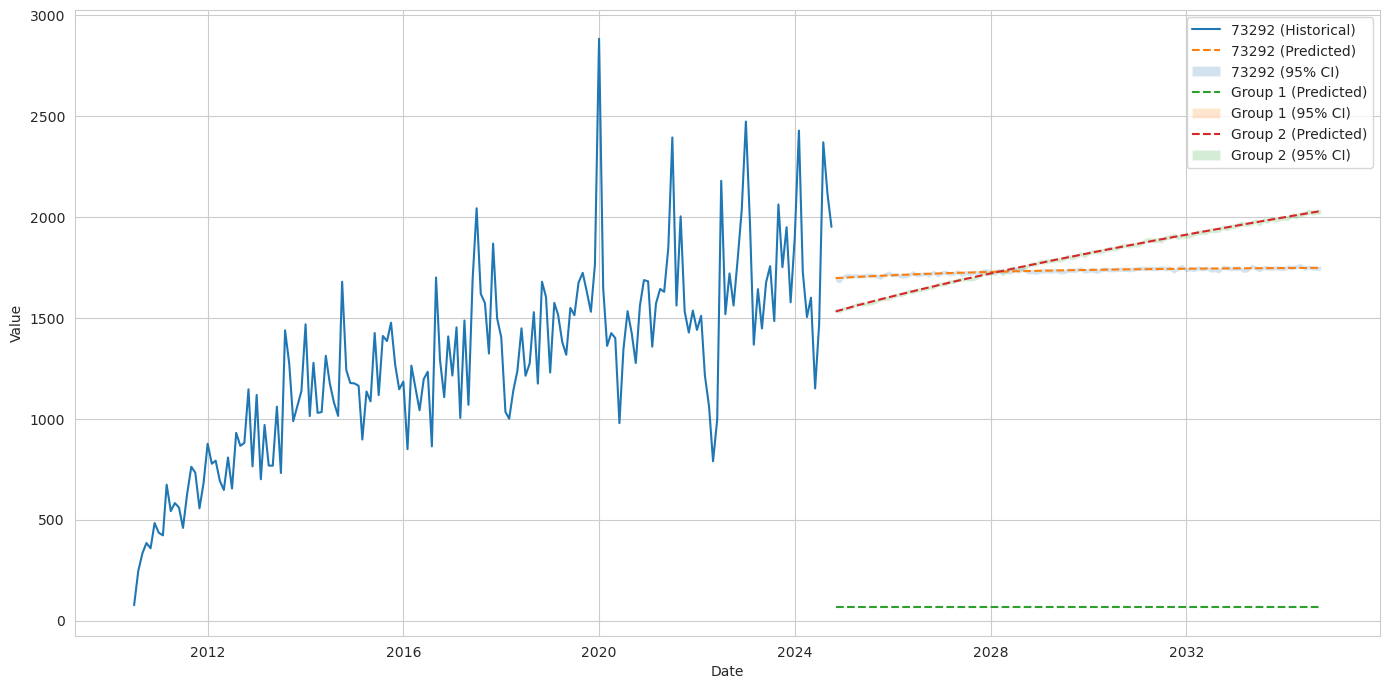

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Define the individual components of each group
group_1_items = ['73358', '73359']
group_2_items = ['73298', '73300', '73358', '73359', '73401', '73402', '73422']

# Define model functions
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize containers
model_predictions = {}
confidence_intervals = {}
historical_data = {}

# Function to calculate bootstrapped CIs
def calculate_bootstrap_ci(data):
    ci = bs.bootstrap(data, stat_func=bs_stats.mean, alpha=0.05)
    return ci.lower_bound, ci.upper_bound

# Process each category
for category in ['73292'] + group_1_items + group_2_items:
    category_data = filtered_data[filtered_data['Item'] == category]['Value'].resample('ME').sum().dropna()

    if category_data.empty:
        print(f"No data found for '{category}'. Skipping...")
        continue

    # Save historical data
    historical_data[category] = category_data

    # Convert to NumPy array
    category_data = category_data.values

    # Create time indices
    current_time_index = np.arange(len(category_data))
    future_time_index = np.arange(len(category_data), len(category_data) + 120)

    try:
        # Fit models
        if category == '73292':
            params, _ = curve_fit(
                gompertz, current_time_index, category_data, maxfev=10000,
                bounds=(0, np.inf)
            )
            fitted_values = gompertz(current_time_index, *params)
            future_predicted = gompertz(future_time_index, *params)
        else:
            params, _ = curve_fit(
                bass_diffusion, current_time_index, category_data, maxfev=10000,
                bounds=(0, [1, 1, np.inf])
            )
            fitted_values = bass_diffusion(current_time_index, *params)
            future_predicted = bass_diffusion(future_time_index, *params)

        # Save predictions
        model_predictions[category] = future_predicted

        # Calculate confidence intervals
        ci_lower = []
        ci_upper = []
        for prediction in future_predicted:
            # Use a small range of values around each prediction for bootstrapping
            sample_data = np.random.normal(loc=prediction, scale=prediction * 0.1, size=1000)
            ci = calculate_bootstrap_ci(sample_data)
            ci_lower.append(ci[0])
            ci_upper.append(ci[1])
        confidence_intervals[category] = (np.array(ci_lower), np.array(ci_upper))

    except Exception as e:
        print(f"Error fitting model for '{category}': {e}")
        continue

# Aggregate group predictions
group_1_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_1_items], axis=0)
group_2_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_2_items], axis=0)

# Aggregate group CIs
group_1_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_1_items], axis=0)
group_1_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_1_items], axis=0)

group_2_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_2_items], axis=0)
group_2_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_2_items], axis=0)

# Save group predictions and CIs
model_predictions['Group 1'] = group_1_predictions
confidence_intervals['Group 1'] = (group_1_ci_lower, group_1_ci_upper)

model_predictions['Group 2'] = group_2_predictions
confidence_intervals['Group 2'] = (group_2_ci_lower, group_2_ci_upper)

# Create future index
future_index = pd.date_range(
    start=historical_data['73292'].index[-1] + pd.offsets.MonthEnd(1),
    periods=120,
    freq='ME'
)

# Plotting
plt.figure(figsize=(14, 7))

# Plot 73292
if '73292' in model_predictions and '73292' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['73292']
    plt.plot(historical_data['73292'].index, historical_data['73292'], label='73292 (Historical)', linestyle='-')
    plt.plot(future_index, model_predictions['73292'], label='73292 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='73292 (95% CI)')

# Plot Group 1
if 'Group 1' in model_predictions and 'Group 1' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['Group 1']
    plt.plot(future_index, model_predictions['Group 1'], label='Group 1 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='Group 1 (95% CI)')

# Plot Group 2
if 'Group 2' in model_predictions and 'Group 2' in confidence_intervals:
    ci_lower, ci_upper = confidence_intervals['Group 2']
    plt.plot(future_index, model_predictions['Group 2'], label='Group 2 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2, label='Group 2 (95% CI)')

# Finalize plot
plt.xlabel('Date')
plt.ylabel('Value')
# plt.title('Historical and Predicted Values with Bootstrapped 95% Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1861/2042835255.py:143: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=120, freq='M')


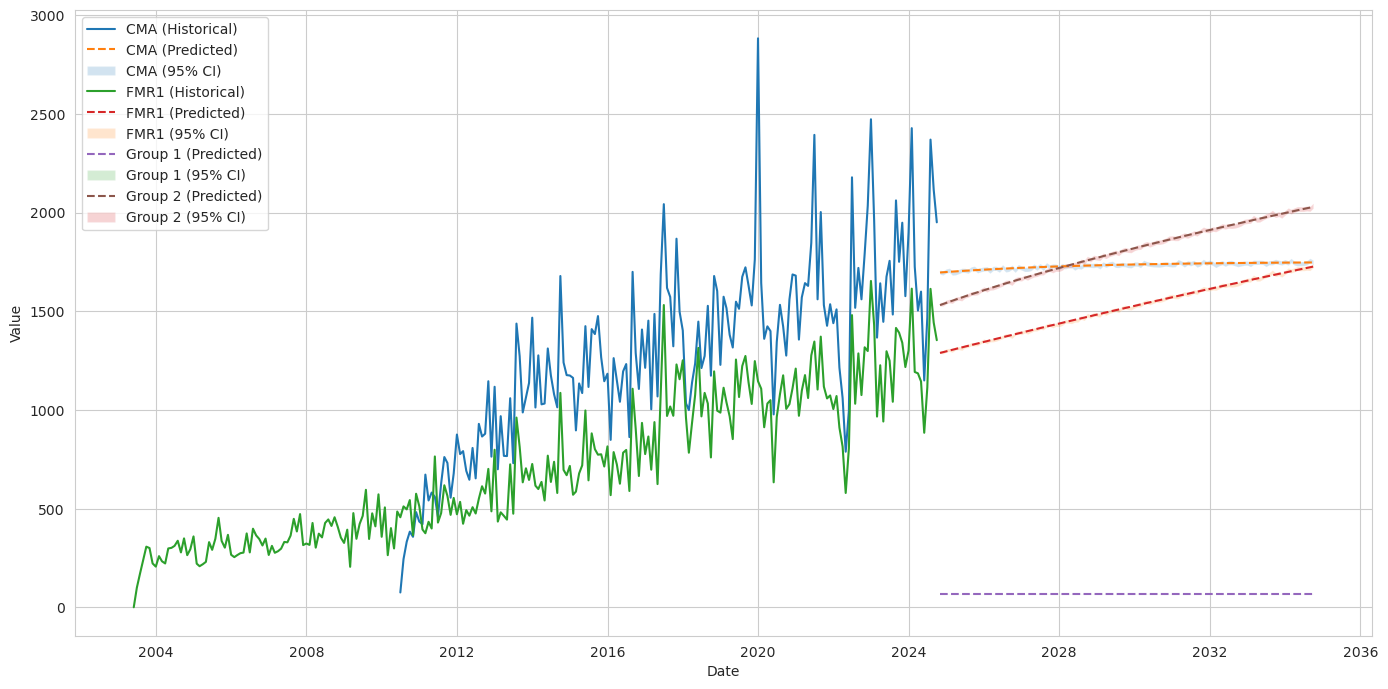

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73292', '73298', '73300', '73358', '73359', '73401', '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Define the individual components of each group
group_1_items = ['73358', '73359']
group_2_items = ['73298', '73300', '73358', '73359', '73401', '73402', '73422']

# Define model functions
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize containers
model_predictions = {}
confidence_intervals = {}
historical_data = {}

# Function to calculate bootstrapped CIs
def calculate_bootstrap_ci(data):
    ci = bs.bootstrap(data, stat_func=bs_stats.mean, alpha=0.05)
    return ci.lower_bound, ci.upper_bound

# -----------------------------
# Process each category individually.
# (Using items_to_include avoids duplicate processing and ensures that '73300' is handled as its own category.)
# -----------------------------
for category in items_to_include:
    # Resample by month end ('ME') and sum the values
    category_data = filtered_data[filtered_data['Item'] == category]['Value'].resample('ME').sum().dropna()

    if category_data.empty:
        print(f"No data found for '{category}'. Skipping...")
        continue

    # Save historical data
    historical_data[category] = category_data

    # Convert to NumPy array for curve fitting
    y_data = category_data.values

    # Create time indices for the historical period and a future period (120 months)
    current_time_index = np.arange(len(y_data))
    future_time_index = np.arange(len(y_data), len(y_data) + 120)

    try:
        # Use Gompertz model for category '73292' and Bass Diffusion for the others.
        if category == '73292':
            params, _ = curve_fit(
                gompertz, current_time_index, y_data, maxfev=10000, bounds=(0, np.inf)
            )
            fitted_values = gompertz(current_time_index, *params)
            future_predicted = gompertz(future_time_index, *params)
        else:
            params, _ = curve_fit(
                bass_diffusion, current_time_index, y_data, maxfev=10000, bounds=(0, [1, 1, np.inf])
            )
            fitted_values = bass_diffusion(current_time_index, *params)
            future_predicted = bass_diffusion(future_time_index, *params)

        # Save predictions for the future period
        model_predictions[category] = future_predicted

        # Calculate confidence intervals using bootstrapping for each future prediction value
        ci_lower = []
        ci_upper = []
        for pred in future_predicted:
            # Generate sample data around the prediction (using 10% of the value as a proxy for standard deviation)
            sample_data = np.random.normal(loc=pred, scale=pred * 0.1, size=1000)
            lower, upper = calculate_bootstrap_ci(sample_data)
            ci_lower.append(lower)
            ci_upper.append(upper)
        confidence_intervals[category] = (np.array(ci_lower), np.array(ci_upper))

    except Exception as e:
        print(f"Error fitting model for '{category}': {e}")
        continue

# -----------------------------
# Aggregate group predictions and confidence intervals
# -----------------------------
group_1_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_1_items], axis=0)
group_2_predictions = np.sum([model_predictions.get(item, np.zeros(120)) for item in group_2_items], axis=0)

group_1_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_1_items], axis=0)
group_1_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_1_items], axis=0)

group_2_ci_lower = np.sum([confidence_intervals.get(item, (np.zeros(120),))[0] for item in group_2_items], axis=0)
group_2_ci_upper = np.sum([confidence_intervals.get(item, (np.zeros(120),))[1] for item in group_2_items], axis=0)

model_predictions['Group 1'] = group_1_predictions
confidence_intervals['Group 1'] = (group_1_ci_lower, group_1_ci_upper)

model_predictions['Group 2'] = group_2_predictions
confidence_intervals['Group 2'] = (group_2_ci_lower, group_2_ci_upper)

# -----------------------------
# Create a future date index.
# (Using the last date from category '73292' as reference; adjust if needed.)
# -----------------------------
if '73292' in historical_data:
    last_date = historical_data['73292'].index[-1]
else:
    last_date = pd.Timestamp.today()

future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=120, freq='ME')

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(14, 7))

# Plot for '73292'
if '73292' in historical_data and '73292' in model_predictions:
    ci_lower, ci_upper = confidence_intervals['73292']
    plt.plot(
        historical_data['73292'].index, historical_data['73292'],
        label=f"{custom_titles.get('73292', '73292')} (Historical)", linestyle='-'
    )
    plt.plot(
        future_index, model_predictions['73292'],
        label=f"{custom_titles.get('73292', '73292')} (Predicted)", linestyle='--'
    )
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                     label=f"{custom_titles.get('73292', '73292')} (95% CI)")

# Plot for '73300' as a separate category
if '73300' in historical_data and '73300' in model_predictions:
    ci_lower, ci_upper = confidence_intervals['73300']
    plt.plot(
        historical_data['73300'].index, historical_data['73300'],
        label=f"{custom_titles.get('73300', '73300')} (Historical)", linestyle='-'
    )
    plt.plot(
        future_index, model_predictions['73300'],
        label=f"{custom_titles.get('73300', '73300')} (Predicted)", linestyle='--'
    )
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                     label=f"{custom_titles.get('73300', '73300')} (95% CI)")

# Plot Group 1 predictions
if 'Group 1' in model_predictions:
    ci_lower, ci_upper = confidence_intervals['Group 1']
    plt.plot(future_index, model_predictions['Group 1'],
             label='Group 1 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                     label='Group 1 (95% CI)')

# Plot Group 2 predictions
if 'Group 2' in model_predictions:
    ci_lower, ci_upper = confidence_intervals['Group 2']
    plt.plot(future_index, model_predictions['Group 2'],
             label='Group 2 (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                     label='Group 2 (95% CI)')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


### Scenario Analysis, CMA

Gompertz model parameters for 73292: [1.75197205e+03 1.35998292e+00 2.18062791e-02]



/tmp/ipykernel_1861/4116873891.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


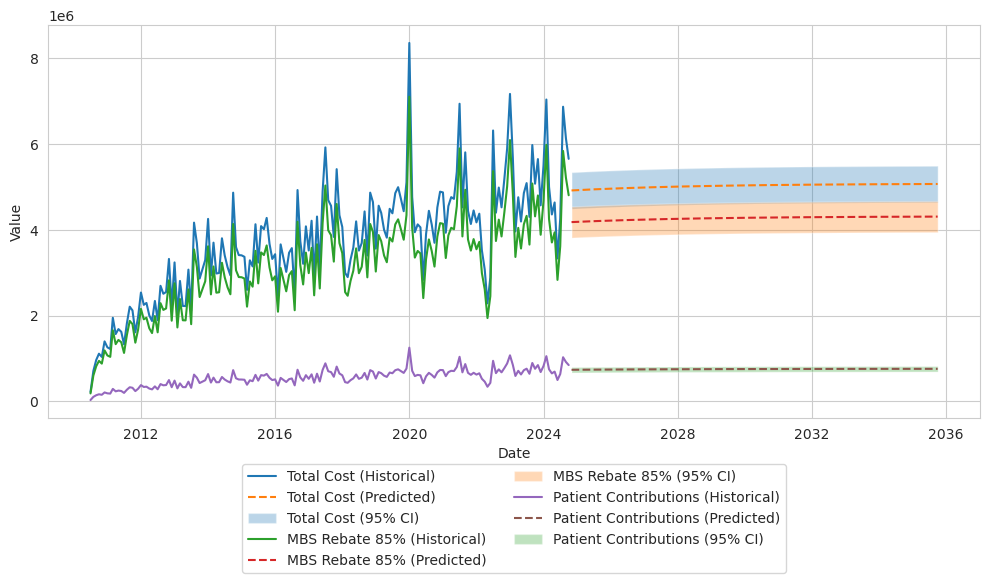

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------
# 1. LOAD AND PREPARE THE DATA
# ---------------------------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is a datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter down to just item 73292
filtered_data = data[data['Item'] == '73292'].copy()
category_data = filtered_data['Value'].resample('ME').sum().dropna()

if category_data.empty:
    print("No data found for '73292'. Exiting...")
    exit()

# ---------------------------
# 2. DEFINE THE GOMPERTZ MODEL
# ---------------------------
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

# ---------------------------
# 3. CREATE MULTIPLIED SERIES
# ---------------------------
category_data_2900 = category_data * 2900
category_data_2465 = category_data * 2465
category_data_435  = category_data * 435

# ---------------------------
# 4. FIT THE GOMPERTZ MODEL
# ---------------------------
# Create time indices for historical and future
current_time_index = np.arange(len(category_data))
future_time_index = np.arange(
    len(category_data),
    len(category_data) + (2035 - category_data.index[-1].year) * 12
)

try:
    # Fit the Gompertz model to the *original* historical series
    params, covariance = curve_fit(gompertz, current_time_index, category_data, maxfev=10000)

    # Calculate the standard deviation of predictions
    std_errors = np.sqrt(np.diag(covariance))
    
    # Generate future predictions (original scale)
    future_predicted = gompertz(future_time_index, *params)

    # Calculate confidence intervals
    ci_upper = future_predicted + 1.96 * std_errors[0]
    ci_lower = future_predicted - 1.96 * std_errors[0]

    print(f"Gompertz model parameters for 73292: {params}\n")

    # Now multiply the predicted values and confidence intervals by the same factors
    future_predicted_2900 = future_predicted * 2900
    ci_upper_2900 = ci_upper * 2900
    ci_lower_2900 = ci_lower * 2900

    future_predicted_2465 = future_predicted * 2465
    ci_upper_2465 = ci_upper * 2465
    ci_lower_2465 = ci_lower * 2465

    future_predicted_435  = future_predicted * 435
    ci_upper_435 = ci_upper * 435
    ci_lower_435 = ci_lower * 435

except Exception as e:
    print(f"Error fitting Gompertz model for '73292': {e}")
    future_predicted = None

# ---------------------------
# 5. PLOT ALL THREE LINES (HIST + PRED + UNCERTAINTY)
# ---------------------------
plt.figure(figsize=(10, 6))

if future_predicted is not None:
    # Build a DateTimeIndex for the future predictions
    future_index = pd.date_range(
        start=category_data.index[-1] + pd.offsets.MonthEnd(1),
        periods=len(future_predicted),
        freq='M'
    )
    
    # Plot Historical x2900
    plt.plot(category_data_2900.index, category_data_2900, label='Total Cost (Historical)', linestyle='-')
    # Plot Predicted x2900 with CI
    plt.plot(future_index, future_predicted_2900, label='Total Cost (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_2900, ci_upper_2900, alpha=0.3, label='Total Cost (95% CI)')

    # Plot Historical x2465
    plt.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85% (Historical)', linestyle='-')
    # Plot Predicted x2465 with CI
    plt.plot(future_index, future_predicted_2465, label='MBS Rebate 85% (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_2465, ci_upper_2465, alpha=0.3, label='MBS Rebate 85% (95% CI)')

    # Plot Historical x435
    plt.plot(category_data_435.index, category_data_435, label='Patient Contributions (Historical)', linestyle='-')
    # Plot Predicted x435 with CI
    plt.plot(future_index, future_predicted_435, label='Patient Contributions (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_435, ci_upper_435, alpha=0.3, label='Patient Contributions (95% CI)')

else:
    # If prediction failed, plot only historical lines
    plt.plot(category_data_2900.index, category_data_2900, label='Total Cost', linestyle='-')
    plt.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85%', linestyle='-')
    plt.plot(category_data_435.index, category_data_435, label='Patient Contributions', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
plt.show()


### Scenario Analysis, FMR1

Gompertz model parameters for 73292: [1.75197205e+03 1.35998292e+00 2.18062791e-02]



/tmp/ipykernel_1861/2396407885.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


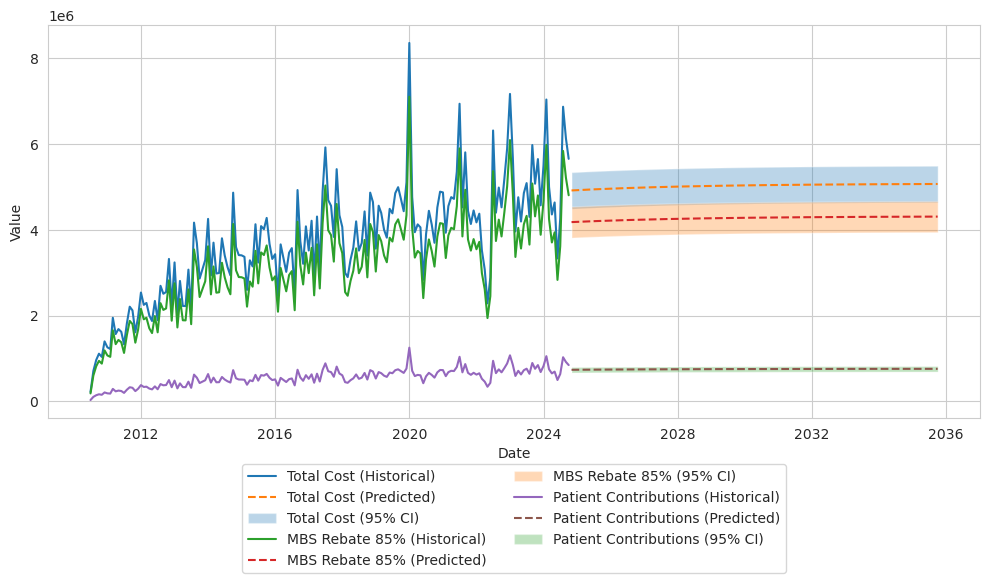

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------
# 1. LOAD AND PREPARE THE DATA
# ---------------------------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is a datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter down to just item 73292 (updated from 73300)
filtered_data = data[data['Item'] == '73292'].copy()
category_data = filtered_data['Value'].resample('ME').sum().dropna()

if category_data.empty:
    print("No data found for '73292'. Exiting...")
    exit()

# ---------------------------
# 2. DEFINE THE GOMPERTZ MODEL
# ---------------------------
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

# ---------------------------
# 3. CREATE MULTIPLIED SERIES
# ---------------------------
category_data_2900 = category_data * 2900
category_data_2465 = category_data * 2465
category_data_435  = category_data * 435

# ---------------------------
# 4. FIT THE GOMPERTZ MODEL
# ---------------------------
# Create time indices for historical and future
current_time_index = np.arange(len(category_data))
future_time_index = np.arange(
    len(category_data),
    len(category_data) + (2035 - category_data.index[-1].year) * 12
)

try:
    # Fit the Gompertz model to the *original* historical series
    params, covariance = curve_fit(gompertz, current_time_index, category_data, maxfev=10000)

    # Calculate the standard deviation of predictions
    std_errors = np.sqrt(np.diag(covariance))
    
    # Generate future predictions (original scale)
    future_predicted = gompertz(future_time_index, *params)

    # Calculate confidence intervals
    ci_upper = future_predicted + 1.96 * std_errors[0]
    ci_lower = future_predicted - 1.96 * std_errors[0]

    print(f"Gompertz model parameters for 73292: {params}\n")

    # Multiply the predicted values and confidence intervals by the same factors
    future_predicted_2900 = future_predicted * 2900
    ci_upper_2900 = ci_upper * 2900
    ci_lower_2900 = ci_lower * 2900

    future_predicted_2465 = future_predicted * 2465
    ci_upper_2465 = ci_upper * 2465
    ci_lower_2465 = ci_lower * 2465

    future_predicted_435  = future_predicted * 435
    ci_upper_435 = ci_upper * 435
    ci_lower_435 = ci_lower * 435

except Exception as e:
    print(f"Error fitting Gompertz model for '73292': {e}")
    future_predicted = None

# ---------------------------
# 5. PLOT ALL THREE LINES (HIST + PRED + UNCERTAINTY)
# ---------------------------
plt.figure(figsize=(10, 6))

if future_predicted is not None:
    # Build a DateTimeIndex for the future predictions
    future_index = pd.date_range(
        start=category_data.index[-1] + pd.offsets.MonthEnd(1),
        periods=len(future_predicted),
        freq='M'
    )
    
    # Plot Historical x2900
    plt.plot(category_data_2900.index, category_data_2900, label='Total Cost (Historical)', linestyle='-')
    # Plot Predicted x2900 with CI
    plt.plot(future_index, future_predicted_2900, label='Total Cost (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_2900, ci_upper_2900, alpha=0.3, label='Total Cost (95% CI)')

    # Plot Historical x2465
    plt.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85% (Historical)', linestyle='-')
    # Plot Predicted x2465 with CI
    plt.plot(future_index, future_predicted_2465, label='MBS Rebate 85% (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_2465, ci_upper_2465, alpha=0.3, label='MBS Rebate 85% (95% CI)')

    # Plot Historical x435
    plt.plot(category_data_435.index, category_data_435, label='Patient Contributions (Historical)', linestyle='-')
    # Plot Predicted x435 with CI
    plt.plot(future_index, future_predicted_435, label='Patient Contributions (Predicted)', linestyle='--')
    plt.fill_between(future_index, ci_lower_435, ci_upper_435, alpha=0.3, label='Patient Contributions (95% CI)')

else:
    # If prediction failed, plot only historical lines
    plt.plot(category_data_2900.index, category_data_2900, label='Total Cost', linestyle='-')
    plt.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85%', linestyle='-')
    plt.plot(category_data_435.index, category_data_435, label='Patient Contributions', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
plt.show()


### Scenario Analysis, CMA vs FMR!

Gompertz model parameters for 73292 (CMA): [1.75193541e+03 1.36000619e+00 2.18080799e-02]

Gompertz model parameters for 73300 (FMR1): [2.67193951e+03 2.64388743e+00 5.16073571e-03]



/tmp/ipykernel_12021/1767130682.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


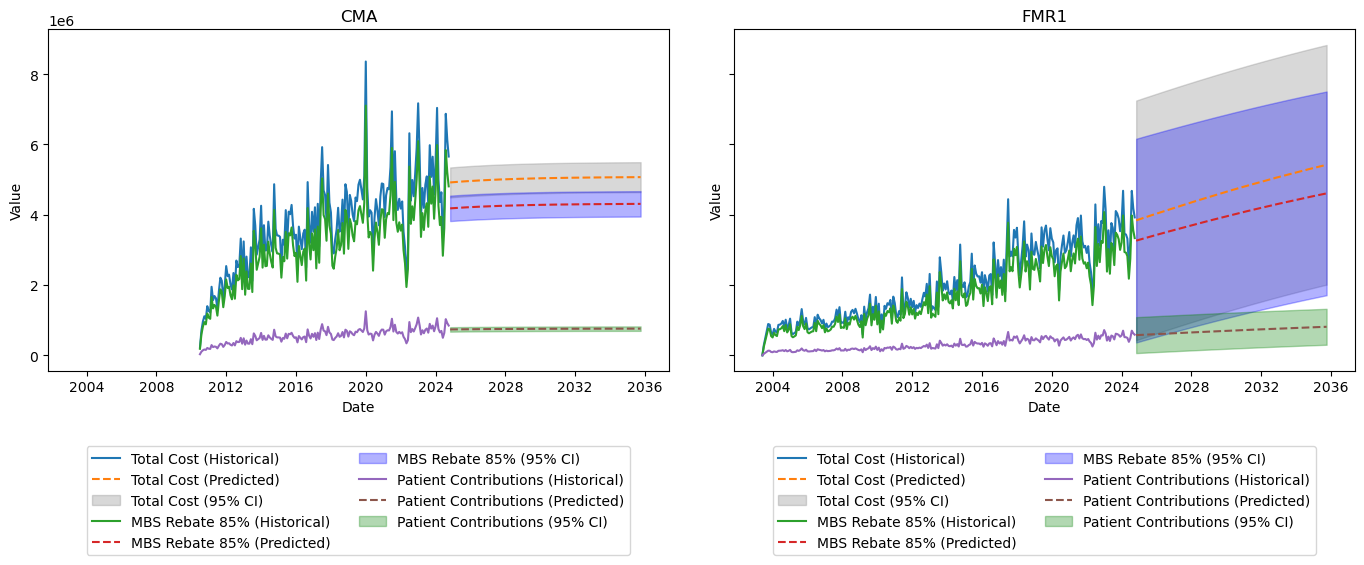

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------
# 1. LOAD AND PREPARE THE DATA
# ---------------------------
file_path = ("/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
             "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
             "MBSGeneticsBenefit_202410.feather")
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column and convert Month to datetime
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# ---------------------------
# 2. DEFINE THE GOMPERTZ MODEL
# ---------------------------
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

# ---------------------------
# 3. SET UP THE ITEMS AND THEIR PLOT LABELS
# ---------------------------
items = ['73292', '73300']
label_map = {'73292': 'CMA', '73300': 'FMR1'}

# Create subplots with shared x and y axes (side-by-side panels)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharex=True, sharey=True)

# ---------------------------
# 4. LOOP OVER ITEMS TO PROCESS & PLOT EACH
# ---------------------------
for ax, item in zip(axes, items):
    # Filter data for the current item and resample to month-end
    filtered_data = data[data['Item'] == item].copy()
    category_data = filtered_data['Value'].resample('ME').sum().dropna()
    
    if category_data.empty:
        print(f"No data found for '{item}'. Skipping this panel...")
        continue

    # Create multiplied series for the three cost components
    category_data_2900 = category_data * 2900
    category_data_2465 = category_data * 2465
    category_data_435  = category_data * 435

    # Create a time index for the historical data
    current_time_index = np.arange(len(category_data))
    # Calculate the number of future months to predict (up to 2035)
    future_months = (2035 - category_data.index[-1].year) * 12
    future_time_index = np.arange(len(category_data), len(category_data) + future_months)
    
    try:
        # Provide an initial guess and bounds to help the optimizer (especially for FMR1)
        initial_guess = [category_data.max(), 1, 0.1]
        params, covariance = curve_fit(
            gompertz,
            current_time_index,
            category_data,
            p0=initial_guess,
            bounds=(0, np.inf),
            maxfev=10000
        )
        std_errors = np.sqrt(np.diag(covariance))
        
        # Generate future predictions (on the original, unmultiplied scale)
        future_predicted = gompertz(future_time_index, *params)
        # Compute a simple 95% confidence interval based on the error in the first parameter
        ci_upper = future_predicted + 1.96 * std_errors[0]
        ci_lower = future_predicted - 1.96 * std_errors[0]

        print(f"Gompertz model parameters for {item} ({label_map.get(item)}): {params}\n")

        # Multiply the predicted values and CIs by the same factors used on the historical series
        future_predicted_2900 = future_predicted * 2900
        ci_upper_2900 = ci_upper * 2900
        ci_lower_2900 = ci_lower * 2900

        future_predicted_2465 = future_predicted * 2465
        ci_upper_2465 = ci_upper * 2465
        ci_lower_2465 = ci_lower * 2465

        future_predicted_435  = future_predicted * 435
        ci_upper_435 = ci_upper * 435
        ci_lower_435 = ci_lower * 435

    except Exception as e:
        print(f"Error fitting Gompertz model for '{item}': {e}")
        future_predicted = None

    # Build a DateTimeIndex for the future predictions based on the last historical date
    future_index = pd.date_range(
        start=category_data.index[-1] + pd.offsets.MonthEnd(1),
        periods=len(future_time_index),
        freq='M'
    )
    
    # ---------------------------
    # 5. PLOT THE RESULTS ON THE CURRENT SUBPLOT
    # ---------------------------
    if future_predicted is not None:
        # Plot Total Cost (multiplied by 2900)
        ax.plot(category_data_2900.index, category_data_2900, label='Total Cost (Historical)', linestyle='-')
        ax.plot(future_index, future_predicted_2900, label='Total Cost (Predicted)', linestyle='--')
        ax.fill_between(future_index, ci_lower_2900, ci_upper_2900, color='gray', alpha=0.3, label='Total Cost (95% CI)')

        # Plot MBS Rebate 85% (multiplied by 2465)
        ax.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85% (Historical)', linestyle='-')
        ax.plot(future_index, future_predicted_2465, label='MBS Rebate 85% (Predicted)', linestyle='--')
        ax.fill_between(future_index, ci_lower_2465, ci_upper_2465, color='blue', alpha=0.3, label='MBS Rebate 85% (95% CI)')

        # Plot Patient Contributions (multiplied by 435)
        ax.plot(category_data_435.index, category_data_435, label='Patient Contributions (Historical)', linestyle='-')
        ax.plot(future_index, future_predicted_435, label='Patient Contributions (Predicted)', linestyle='--')
        ax.fill_between(future_index, ci_lower_435, ci_upper_435, color='green', alpha=0.3, label='Patient Contributions (95% CI)')
    else:
        # If the model fitting failed, plot only historical data
        ax.plot(category_data_2900.index, category_data_2900, label='Total Cost', linestyle='-')
        ax.plot(category_data_2465.index, category_data_2465, label='MBS Rebate 85%', linestyle='-')
        ax.plot(category_data_435.index, category_data_435, label='Patient Contributions', linestyle='-')
    
    # Set the subplot title to the appropriate label ("CMA" or "FMR1")
    ax.set_title(label_map.get(item, item))
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.tight_layout()
plt.show()


## Tables

### Utilisation, Overall, Annual

In [ ]:
import pandas as pd

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Aggregate 'Value' by year (using 'YE' for year-end frequency)
annual_data = filtered_data['Value'].resample('YE').sum()

# Ensure the year is displayed correctly (only the year)
annual_data.index = annual_data.index.year

# Reverse the data for backward year calculation
annual_data = annual_data[::-1]

# Add reverse year index
reverse_years = range(1, len(annual_data) + 1)

# Convert to a DataFrame and add the reverse year index
annual_data_table = annual_data.reset_index()
annual_data_table.columns = ['Actual Year', 'Annual Count of Services']  # Explicitly rename columns
annual_data_table['Reverse Year'] = reverse_years
annual_data_table['Annual Count of Services'] = annual_data_table['Annual Count of Services'].astype(int)

# Reorder columns for clarity
annual_data_table = annual_data_table[['Reverse Year', 'Actual Year', 'Annual Count of Services']]

# Display the table
annual_data_table


### Utilisation, Overall, Annual

In [10]:
import pandas as pd

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Aggregate 'Value' by year (using 'YE' for year-end frequency)
annual_data = filtered_data.groupby('Item')['Value'].resample('YE').sum()

# Pivot the data to have a column for each category
annual_data_table = annual_data.reset_index().pivot(index='Month', columns='Item', values='Value')

# Reverse the order of years
annual_data_table = annual_data_table.iloc[::-1]

# Add the reverse year index and rename the columns
reverse_years = range(1, len(annual_data_table) + 1)
annual_data_table['Reverse Year'] = reverse_years
annual_data_table['Actual Year'] = annual_data_table.index.year

# Reorder columns to have year-related columns first
annual_data_table.reset_index(drop=True, inplace=True)
annual_data_table = annual_data_table[['Reverse Year', 'Actual Year'] + [col for col in annual_data_table.columns if col not in ['Reverse Year', 'Actual Year']]]

# Replace NaN with zeros and ensure all values are integers
annual_data_table.fillna(0, inplace=True)
annual_data_table = annual_data_table.astype(int)

annual_data_table

Item  Reverse Year  Actual Year  73287  73289  73292  73298  73300  73358  \
0                1         2024   8200  61213  16314    104  11550     98   
1                2         2023   9566  73785  20571    160  14825    124   
2                3         2022   9102  56974  18850    147  13331    140   
3                4         2021  11159  71287  19940    125  13664    119   
4                5         2020  11341  57149  17312     94  12315      4   
5                6         2019   9983  58146  20055     17  13358      0   
6                7         2018  13843  51403  15558      0  12101      0   
7                8         2017  12308  51885  18028      0  12347      0   
8                9         2016  11150  48766  14315      0   9272      0   
9               10         2015  12436  44735  14691      0   8963      0   
10              11         2014  14358  44635  14205      0   8289      0   
11              12         2013  15988  41048  12363      0   7514      0   
12              13         2012  17483  33106  10074      0   6631      0   
13              14         2011  17603  29646   7471      0   5958      0   
14              15         2010  23238  30025   2314      0   5424      0   
15              16         2009  26470  30607      0      0   5075      0   
16              17         2008  23351  28147      0      0   4610      0   
17              18         2007  23311  24245      0      0   4145      0   
18              19         2006  23133  22513      0      0   3767      0   
19              20         2005  22988  21733      0      0   3581      0   
20              21         2004  21838  20072      0      0   3517      0   
21              22         2003  22934  17568      0      0   1552      0   
22              23         2002  21407  14872      0      0      0      0   
23              24         2001  22335  15192      0      0      0      0   
24              25         2000  20033  13868      0      0      0      0   
25              26         1999  21181  14615      0      0      0      0   
26              27         1998  20055  12992      0      0      0      0   
27              28         1997  20153  11147      0      0      0      0   
28              29         1996  16407  11216      0      0      0      0   
29              30         1995  15495  10282      0      0      0      0   
30              31         1994  15768   7316      0      0      0      0   
31              32         1993   4671   2450      0      0      0      0   

Item  73359  73401  73402  73422  
0       452    205    402    871  
1       701    166    319    569  
2       609     25     41      0  
3       650      0      0      0  
4        69      0      0      0  
5         0      0      0      0  
6         0      0      0      0  
7         0      0      0      0  
8         0      0      0      0  
9         0      0      0      0  
10        0      0      0      0  
11        0      0      0      0  
12        0      0      0      0  
13        0      0      0      0  
14        0      0      0      0  
15        0      0      0      0  
16        0      0      0      0  
17        0      0      0      0  
18        0      0      0      0  
19        0      0      0      0  
20        0      0      0      0  
21        0      0      0      0  
22        0      0      0      0  
23        0      0      0      0  
24        0      0      0      0  
25        0      0      0      0  
26        0      0      0      0  
27        0      0      0      0  
28        0      0      0      0  
29        0      0      0      0  
30        0      0      0      0  
31        0      0      0      0

### Utilisation, Pred vs Actual

In [16]:
import pandas as pd

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73300', '73358', '73359', '73360', '73395', '73298', '73299', '73401',
    '73402', '73422', '73425', '73426', '73442', '73456', '73457', '73458', '73398'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Combine 73358 and 73359 into a single item '73358_73359'
filtered_data.loc[:, 'Item'] = filtered_data['Item'].replace({'73359': '73358_73359', '73358': '73358_73359'})

# Calculate 'Relative Year'
filtered_data['Year'] = filtered_data.index.year
filtered_data['First Year'] = filtered_data.groupby('Item')['Year'].transform('min')
filtered_data['Relative Year'] = filtered_data['Year'] - filtered_data['First Year'] + 1

# Ensure only the first 5 years of data
filtered_data = filtered_data[filtered_data['Relative Year'] <= 5]
grouped_data = filtered_data.groupby(['Item', 'Relative Year'])['Value'].sum().unstack(fill_value=0)
grouped_data.columns = [f'Actual Year {i}' for i in range(1, 6)]

# Predicted values (annual)
predicted_values = {
    '73300': [7500, 7500, 7500, 7500, 7500],
    '73358_73359': [3406, 3454, 3503, 2753, 2803],
    '73398': [2300, 1170, 1190, 1210, 1230],
    '73401': [789, 723, 796, 715, 805],
    '73402': [27, 25, 28, 25, 28],
    '73422': [4472, 5106, 5454, 5499, 5285],
    '73298': [1000, 1100, 1200, 1300, 1400]
}
predicted_df = pd.DataFrame.from_dict(predicted_values, orient='index', columns=[f'Predicted Year {i}' for i in range(1, 6)])

# Combine actual and predicted values into a single table
result_table = grouped_data.join(predicted_df, how='outer').reset_index()

# Add percentage columns
for year in range(1, 6):
    actual_col = f'Actual Year {year}'
    predicted_col = f'Predicted Year {year}'
    percentage_col = f'Percentage Year {year}'
    
    # Calculate percentage and handle potential division by zero
    result_table[percentage_col] = (result_table[actual_col] / result_table[predicted_col]) * 100

# Display the table
print(result_table)


         index  Actual Year 1  Actual Year 2  Actual Year 3  Actual Year 4  \
0        73298           17.0           94.0          125.0          147.0   
1        73300         1552.0         3517.0         3581.0         3767.0   
2  73358_73359           73.0          769.0          749.0          825.0   
3        73398          511.0         2011.0         1784.0            0.0   
4        73401           25.0          166.0          205.0            0.0   
5        73402           41.0          319.0          402.0            0.0   
6        73422          569.0          871.0            0.0            0.0   

   Actual Year 5  Predicted Year 1  Predicted Year 2  Predicted Year 3  \
0          160.0              1000              1100              1200   
1         4145.0              7500              7500              7500   
2          550.0              3406              3454              3503   
3            0.0              2300              1170              1190   
4    

### Diffusion Innovation Models, Performance Measures, Overall

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create two new virtual “Item” groups --

# 1) Combine items 73358 and 73359
combined_73358_59 = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59['Item'] = '73358-73359-Combined'

# 2) Combine items 73358, 73359, 73298, 73401, 73402, 73422
combined_73358_59_plus = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59_plus['Item'] = '73358-73359-73298-73401-73402-73422-Combined'

# Now append these combined items back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),       # Original data
        combined_73358_59,                  # 73358+73359
        combined_73358_59_plus              # Combined group
    ],
    ignore_index=True
)

# Re-set index to Month
filtered_data.set_index('Month', inplace=True)

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD',   
    # Add more mappings if needed.
}

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize dictionaries for results
model_results = []
problematic_items = []

# Iterate through each item and fit models
for item in valid_items:
    # Resample by month-end, sum, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue
    
    time_index = np.arange(len(item_data))
    
    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    for model_name, model_func in models.items():
        try:
            # Fit the model
            params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")
    
    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = 1 - np.sum((item_data - sarima_pred) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
        
        model_results.append({
            'Item': item,
            'Model': "SARIMA",
            'r2': sarima_r2,
            'MAE': mean_absolute_error(item_data, sarima_pred),
            'MAPE': mean_absolute_percentage_error(item_data, sarima_pred)
        })
        
        if sarima_r2 < -1 or sarima_r2 > 1:
            problematic_items.append({
                'Item': item,
                'Model': "SARIMA",
                'R2': sarima_r2
            })
    except Exception as e:
        print(f"Error fitting SARIMA for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item:")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis:")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:83: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)


Error fitting Gompertz for item 73287: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:83: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/1003700687.py:83: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/10037

Best Models for Each Item:
                                            Item  \
2                                          73287   
6                                          73289   
10                                         73292   
12                                         73298   
18                                         73300   
20                                         73358   
25  73358-73359-73298-73401-73402-73422-Combined   
29                          73358-73359-Combined   
33                                         73359   
36                                         73401   
40                                         73402   
45                                         73422   

                                      Item_title           Model        r2  \
2                                          KT-NB          SARIMA  0.780500   
6                                          KT-BL          SARIMA  0.918212   
10                                           CMA          SARI

/tmp/ipykernel_1861/1003700687.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/1003700687.py:83: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/1003700687.py:86: RuntimeWarning: overflow encountered in exp
  return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
/tmp/ipykernel_1861/1003700687.py:86: RuntimeWarning: invalid value encountered in divide
  return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
/tmp/ipykernel_1861/1003700687.py:86: RuntimeWarning: overflow encountered in multiply
  return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters ex

### Diffusion Innovation Models, Performance Measures, First 5 Years

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create two new virtual “Item” groups --

# 1) Combine items 73358 and 73359
combined_73358_59 = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59['Item'] = '73358-73359-Combined'

# 2) Combine items 73358, 73359, 73298, 73401, 73402, 73422
combined_73358_59_plus = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59_plus['Item'] = '73358-73359-73298-73401-73402-73422-Combined'

# Now append these combined items back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),       # Original data
        combined_73358_59,                  # 73358+73359
        combined_73358_59_plus              # Combined group
    ],
    ignore_index=True
)

# Re-set index to Month
filtered_data.set_index('Month', inplace=True)

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD',   
    # Add more mappings if needed.
}

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each item and fit models using only the first five years of data
for item in valid_items:
    # Resample by month-end, sum, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue
    
    # Use only the first five years (approximately 60 months) of data.
    if len(item_data) >= 60:
        item_data = item_data.iloc[:60]
    else:
        item_data = item_data.copy()
    
    time_index = np.arange(len(item_data))
    
    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    for model_name, model_func in models.items():
        try:
            # Fit the model
            params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")
    
    # Fit SARIMA model using only the first five years of data
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = 1 - np.sum((item_data - sarima_pred) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
        
        model_results.append({
            'Item': item,
            'Model': "SARIMA",
            'r2': sarima_r2,
            'MAE': mean_absolute_error(item_data, sarima_pred),
            'MAPE': mean_absolute_percentage_error(item_data, sarima_pred)
        })
        
        if sarima_r2 < -1 or sarima_r2 > 1:
            problematic_items.append({
                'Item': item,
                'Model': "SARIMA",
                'R2': sarima_r2
            })
    except Exception as e:
        print(f"Error fitting SARIMA for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/334589385.py:83: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/334589385.py:83: RuntimeWarning: overflow encountered in exp
  re

Error fitting Gompertz for item 73287: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Error fitting Gompertz for item 73289: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/334589385.py:83: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))


Error fitting Gompertz for item 73292: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


/tmp/ipykernel_1861/334589385.py:119: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_1861/334589385.py:80: RuntimeWarning: overflow encount

Best Models for Each Item (using only the first five years of data):
                                            Item  \
2                                          73287   
5                                          73289   
8                                          73292   
10                                         73298   
16                                         73300   
18                                         73358   
24  73358-73359-73298-73401-73402-73422-Combined   
27                          73358-73359-Combined   
31                                         73359   
34                                         73401   
38                                         73402   
43                                         73422   

                                      Item_title           Model        r2  \
2                                          KT-NB          SARIMA  0.346257   
5                                          KT-BL          SARIMA  0.539579   
8                   

/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create two new virtual “Item” groups --

# 1) Combine items 73358 and 73359
combined_73358_59 = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59['Item'] = '73358-73359-Combined'

# 2) Combine items 73358, 73359, 73298, 73401, 73402, 73422
combined_73358_59_plus = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
combined_73358_59_plus['Item'] = '73358-73359-73298-73401-73402-73422-Combined'

# Now append these combined items back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),       # Original data
        combined_73358_59,                  # 73358+73359
        combined_73358_59_plus              # Combined group
    ],
    ignore_index=True
)

# Re-set index to Month
filtered_data.set_index('Month', inplace=True)

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD',   
    # Add more mappings if needed.
}

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each item and fit only the diffusion models using the first five years of data
for item in valid_items:
    # Resample by month-end, sum, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue
    
    # Use only the first five years (approximately 60 months) of data for this item.
    if len(item_data) >= 60:
        item_data = item_data.iloc[:60]
    else:
        item_data = item_data.copy()
    
    time_index = np.arange(len(item_data))
    
    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    for model_name, model_func in models.items():
        try:
            # Fit the model
            params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


Error fitting Gompertz for item 73287: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Error fitting Gompertz for item 73289: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Error fitting Gompertz for item 73292: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Best Models for Each Item (using only the first five years of data):
                                            Item  \
1                                          73287   
3                                          73289   
5                                          73292   
7                                          73298   
10                                         73300   
13                                         73358   
17  73358-73359-73298-73401-73402-73422-Combined   
20                          73358-73359-Combined   
23                                         73359   
25                                  

/tmp/ipykernel_1861/3012150462.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/3012150462.py:82: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/3012150462.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/3012150462.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/3012150462.py:82: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_1861/3012150462.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_1861/3012150462

### Scenario Analyses, Benefit, CMA and FMR1

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ----------------------------------------------------------------------
# 1. LOAD DATA AND FILTER TO ITEM 73292
# ----------------------------------------------------------------------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean & set index
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter to just 73292
filtered_data = data[data['Item'] == '73292'].copy()
category_data = filtered_data['Value'].resample('MS').sum().dropna()

if category_data.empty:
    print("No data for item '73292'. Exiting...")
    raise SystemExit

# ----------------------------------------------------------------------
# 2. DEFINE GOMPERTZ MODEL
# ----------------------------------------------------------------------
def gompertz(t, a, b, c):
    """
    Gompertz function:
    y(t) = a * exp(-b * exp(-c * t))
    """
    return a * np.exp(-b * np.exp(-c * t))

# ----------------------------------------------------------------------
# 3. FIT THE MODEL & GET PARAMS + COVARIANCE
# ----------------------------------------------------------------------
current_time_index = np.arange(len(category_data))
final_year = 2035
months_to_predict = (final_year - category_data.index[-1].year) * 12

future_time_index = np.arange(len(category_data), len(category_data) + months_to_predict)

try:
    params, pcov = curve_fit(gompertz, current_time_index, category_data, maxfev=10000)
    print("Fitted Gompertz parameters:", params)
except Exception as e:
    print(f"Error fitting Gompertz model: {e}")
    raise

# ----------------------------------------------------------------------
# 4. PARAMETRIC BOOTSTRAP FOR 95% CIs
# ----------------------------------------------------------------------
n_boot = 1000  # Number of bootstrap draws
np.random.seed(42)

param_samples = np.random.multivariate_normal(params, pcov, size=n_boot)

boot_predictions = []
for sample in param_samples:
    pred_sample = gompertz(future_time_index, *sample)
    boot_predictions.append(pred_sample)

boot_predictions = np.array(boot_predictions)

# ----------------------------------------------------------------------
# 5. AGGREGATE TO YEARLY SUM AND MULTIPLY BY 2900, 2465, 435
# ----------------------------------------------------------------------
future_index = pd.date_range(
    start=category_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=len(future_time_index),
    freq='MS'
)

df_future_boot = pd.DataFrame(boot_predictions.T, index=future_index)

df_future_boot["Year"] = df_future_boot.index.year
grouped_boot = df_future_boot.groupby("Year")

yearly_sums = {}
unique_years = sorted(df_future_boot["Year"].unique())

for yr in unique_years:
    sums_for_year = grouped_boot.get_group(yr).drop(columns="Year").sum(axis=0).values
    yearly_sums[yr] = sums_for_year

factor_list = [2900, 2465, 435]
factor_labels = ["x2900", "x2465", "x435"]

rows = []
for yr in unique_years:
    row_dict = {"Year": yr}
    boot_array = yearly_sums[yr]

    for factor, label in zip(factor_list, factor_labels):
        vals = boot_array * factor
        median_val = np.percentile(vals, 50)
        lower_val  = np.percentile(vals, 2.5)
        upper_val  = np.percentile(vals, 97.5)

        # Format as integer with comma separators and bracketed CI
        row_dict[label] = f"{int(round(median_val)):,} ({int(round(lower_val)):,}-{int(round(upper_val)):,})"
    
    rows.append(row_dict)

results_df = pd.DataFrame(rows)
results_df.set_index("Year", inplace=True)

# ----------------------------------------------------------------------
# 6. DISPLAY THE RESULTS TABLE
# ----------------------------------------------------------------------
print("\nBootstrapped 95% CI Table (Yearly Sums):")
results_df


Fitted Gompertz parameters: [1.75197205e+03 1.35998292e+00 2.18062791e-02]

Bootstrapped 95% CI Table (Yearly Sums):


x2900                               x2465  \
Year                                                                           
2024  14,717,311 (13,770,553-15,376,384)  12,509,714 (11,704,970-13,069,927)   
2025  59,154,134 (55,186,817-61,904,977)  50,281,014 (46,908,794-52,619,230)   
2026  59,500,294 (55,321,357-62,425,102)  50,575,250 (47,023,153-53,061,337)   
2027  59,791,857 (55,433,772-62,843,262)  50,823,078 (47,118,706-53,416,773)   
2028  60,014,313 (55,514,841-63,206,692)  51,012,166 (47,187,615-53,725,688)   
2029  60,191,395 (55,573,277-63,556,167)  51,162,685 (47,237,285-54,022,742)   
2030  60,336,393 (55,615,383-63,841,698)  51,285,934 (47,273,075-54,265,443)   
2031  60,466,006 (55,646,052-64,076,996)  51,396,105 (47,299,144-54,465,447)   
2032  60,552,191 (55,672,653-64,255,371)  51,469,362 (47,321,755-54,617,065)   
2033  60,614,091 (55,697,036-64,444,696)  51,521,977 (47,342,481-54,777,992)   
2034  60,654,243 (55,715,276-64,669,000)  51,556,106 (47,357,985-54,968,650)   
2035  45,522,632 (41,795,616-48,636,599)  38,694,237 (35,526,274-41,341,109)   

                                 x435  
Year                                   
2024  2,207,597 (2,065,583-2,306,458)  
2025  8,873,120 (8,278,022-9,285,747)  
2026  8,925,044 (8,298,204-9,363,765)  
2027  8,968,778 (8,315,066-9,426,489)  
2028  9,002,147 (8,327,226-9,481,004)  
2029  9,028,709 (8,335,992-9,533,425)  
2030  9,050,459 (8,342,307-9,576,255)  
2031  9,069,901 (8,346,908-9,611,549)  
2032  9,082,829 (8,350,898-9,638,306)  
2033  9,092,114 (8,354,555-9,666,704)  
2034  9,098,136 (8,357,291-9,700,350)  
2035  6,828,395 (6,269,342-7,295,490)

In [87]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# ---------------------------
# 1. LOAD AND PREPARE THE DATA
# ---------------------------
file_path = (
    "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
    "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
    "MBSGeneticsBenefit_202410.feather"
)
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column and convert Month to datetime
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# ---------------------------
# 2. DEFINE THE GOMPERTZ MODEL
# ---------------------------
def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

# ---------------------------
# 3. SET UP THE ITEMS AND THEIR LABELS
# ---------------------------
items = ['73292', '73300']
label_map = {'73292': 'CMA', '73300': 'FMR1'}

# Dictionary to store the resulting tables for each item
tables = {}

# ---------------------------
# 4. PROCESS EACH ITEM AND CREATE A TABLE OF PREDICTIONS
# ---------------------------
# We will predict for the first 5 future years (5*12 months)
future_months = 5 * 12

for item in items:
    # Filter data for the current item and resample to month-end
    filtered_data = data[data['Item'] == item].copy()
    category_data = filtered_data['Value'].resample('ME').sum().dropna()
    
    if category_data.empty:
        print(f"No data found for '{item}'. Skipping...")
        continue

    # Create a time index for the historical data
    current_time_index = np.arange(len(category_data))
    future_time_index = np.arange(len(category_data), len(category_data) + future_months)
    
    try:
        # Provide an initial guess and bounds to help the optimizer.
        # (Initial guess here: [max observed value, 1, 0.1])
        initial_guess = [category_data.max(), 1, 0.1]
        params, covariance = curve_fit(
            gompertz,
            current_time_index,
            category_data,
            p0=initial_guess,
            bounds=(0, np.inf),
            maxfev=10000
        )
        std_errors = np.sqrt(np.diag(covariance))
        
        # Generate future predictions on the original (unmultiplied) scale
        future_predicted = gompertz(future_time_index, *params)
        # Compute a simple 95% confidence interval using only the error on the first parameter
        ci_upper = future_predicted + 1.96 * std_errors[0]
        ci_lower = future_predicted - 1.96 * std_errors[0]
        
        print(f"Gompertz model parameters for {item} ({label_map.get(item)}): {params}")
    except Exception as e:
        print(f"Error fitting Gompertz model for '{item}': {e}")
        continue

    # Build a DateTimeIndex for the future predictions starting one month after the last historical date
    future_index = pd.date_range(
        start=category_data.index[-1] + pd.offsets.MonthEnd(1),
        periods=future_months,
        freq='M'
    )
    
    # Multiply the predicted values and CIs by the cost factors:
    #  - 2900 for Total Cost
    #  - 2465 for MBS Rebate 85%
    #  - 435  for Patient Contributions
    pred_2900 = future_predicted * 2900
    lower_2900 = ci_lower * 2900
    upper_2900 = ci_upper * 2900
    
    pred_2465 = future_predicted * 2465
    lower_2465 = ci_lower * 2465
    upper_2465 = ci_upper * 2465
    
    pred_435 = future_predicted * 435
    lower_435 = ci_lower * 435
    upper_435 = ci_upper * 435
    
    # Create a DataFrame of monthly predictions and CIs
    df_future = pd.DataFrame({
        'pred_2900': pred_2900,
        'lower_2900': lower_2900,
        'upper_2900': upper_2900,
        'pred_2465': pred_2465,
        'lower_2465': lower_2465,
        'upper_2465': upper_2465,
        'pred_435': pred_435,
        'lower_435': lower_435,
        'upper_435': upper_435
    }, index=future_index)
    df_future['Year'] = df_future.index.year
    
    # Aggregate the monthly predictions to yearly sums
    grouped = df_future.groupby('Year').sum()
    
    # Build a table (one row per future year) with formatted strings:
    rows = []
    for yr in grouped.index:
        row = {
            'Year': yr,
            'Total Cost (x2900)': f"{int(round(grouped.loc[yr, 'pred_2900'])):,} "
                                   f"({int(round(grouped.loc[yr, 'lower_2900'])):,}-{int(round(grouped.loc[yr, 'upper_2900'])):,})",
            'MBS Rebate 85% (x2465)': f"{int(round(grouped.loc[yr, 'pred_2465'])):,} "
                                      f"({int(round(grouped.loc[yr, 'lower_2465'])):,}-{int(round(grouped.loc[yr, 'upper_2465'])):,})",
            'Patient Contributions (x435)': f"{int(round(grouped.loc[yr, 'pred_435'])):,} "
                                            f"({int(round(grouped.loc[yr, 'lower_435'])):,}-{int(round(grouped.loc[yr, 'upper_435'])):,})"
        }
        rows.append(row)
    
    results_df = pd.DataFrame(rows).set_index('Year')
    tables[label_map.get(item, item)] = results_df

# ---------------------------
# 5. DISPLAY THE RESULTS TABLES
# ---------------------------
for label, table in tables.items():
    print(f"\nPredicted Performance Measures for {label} (Next 5 Years):")
    print(table)

    


Gompertz model parameters for 73292 (CMA): [1.75193541e+03 1.36000619e+00 2.18080799e-02]
Gompertz model parameters for 73300 (FMR1): [2.67193951e+03 2.64388743e+00 5.16073571e-03]

Predicted Performance Measures for CMA (Next 5 Years):
                      Total Cost (x2900)              MBS Rebate 85% (x2465)  \
Year                                                                           
2024  14,772,628 (13,496,716-16,048,540)  12,556,734 (11,472,208-13,641,259)   
2025  59,365,844 (54,262,195-64,469,493)  50,460,967 (46,122,866-54,799,069)   
2026  59,730,810 (54,627,162-64,834,459)  50,771,189 (46,433,087-55,109,290)   
2027  60,013,277 (54,909,629-65,116,926)  51,011,286 (46,673,184-55,349,387)   
2028  60,231,619 (55,127,971-65,335,268)  51,196,876 (46,858,775-55,534,978)   
2029  45,286,638 (41,458,901-49,114,374)  38,493,642 (35,240,066-41,747,218)   

         Patient Contributions (x435)  
Year                                   
2024  2,215,894 (2,024,507-2,407,281)  
20

/tmp/ipykernel_1861/4045303768.py:80: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(
/tmp/ipykernel_1861/4045303768.py:80: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


### Scenario Analysis, By Group

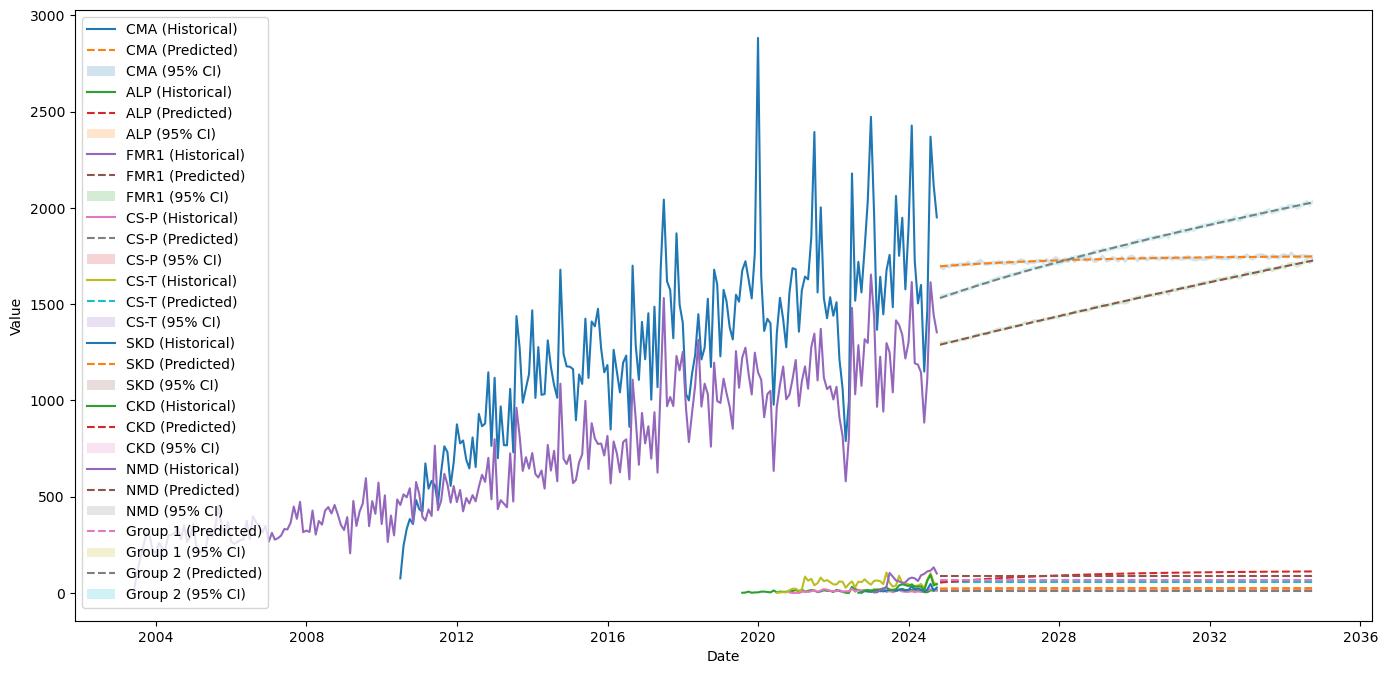


Results Table (Annual Summary):
    Year                73292                73300        Group 1  \
0   2020          17312 (N/A)          12315 (N/A)        0 (N/A)   
1   2021          19940 (N/A)          13664 (N/A)        0 (N/A)   
2   2022          18850 (N/A)          13331 (N/A)        0 (N/A)   
3   2023          20571 (N/A)          14825 (N/A)        0 (N/A)   
4   2024          16314 (N/A)          11550 (N/A)        0 (N/A)   
5   2025  20434 (20304–20555)  15736 (15652–15847)  797 (791–801)   
6   2026  20568 (20459–20712)  16307 (16234–16434)  797 (792–802)   
7   2027  20672 (20532–20785)  16868 (16776–16983)  797 (791–801)   
8   2028  20752 (20645–20904)  17417 (17285–17504)  797 (791–801)   
9   2029  20814 (20671–20929)  17956 (17826–18050)  797 (792–802)   
10  2030  20862 (20740–20996)  18484 (18363–18594)  797 (791–801)   
11  2031  20899 (20727–20987)  19003 (18863–19099)  797 (792–802)   
12  2032  20927 (20766–21025)  19511 (19413–19654)  797 (790–800)   
1

/tmp/ipykernel_12021/2308647887.py:229: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hist_annual = historical_data['73292'].resample('Y').sum()
/tmp/ipykernel_12021/2308647887.py:248: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_series = historical_data[category].resample('Y').sum()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats

# =============================================================================
# 1. Helper Functions
# =============================================================================

def load_and_prepare_data(file_path, items_to_include):
    """
    Load data from the feather file, clean the 'Item' column and set the 'Month'
    column as a datetime index. Then filter by the given item codes.
    """
    data = pd.read_feather(file_path)
    data['Item'] = data['Item'].astype(str).str.strip()
    data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
    data.set_index('Month', inplace=True)
    filtered_data = data[data['Item'].isin(items_to_include)].copy()
    return filtered_data

def gompertz(t, a, b, c):
    """Gompertz model function."""
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    """Bass Diffusion model function."""
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

def calculate_bootstrap_ci(data):
    """
    Calculate a 95% bootstrapped confidence interval of the mean using the
    bootstrapped package.
    """
    ci = bs.bootstrap(data, stat_func=bs_stats.mean, alpha=0.05)
    return ci.lower_bound, ci.upper_bound

def process_category(category, filtered_data, resample_rule, future_periods):
    """
    Resample the historical data for a given category, fit the chosen model,
    forecast future predictions, and calculate bootstrap CIs.
    
    Parameters:
      - category: the item code as a string.
      - filtered_data: the prepared DataFrame.
      - resample_rule: resampling frequency (e.g. 'ME' for month-end).
      - future_periods: number of future periods to forecast.
    
    Returns:
      - historical: the historical series.
      - future_pred: a NumPy array of model predictions for the future.
      - ci: a tuple (lower bounds, upper bounds) for each future prediction.
    """
    # Resample and sum the values
    series = filtered_data[filtered_data['Item'] == category]['Value'].resample(resample_rule).sum().dropna()
    if series.empty:
        print(f"No data found for '{category}'. Skipping...")
        return None, None, None
    historical = series.copy()
    
    # Prepare data for curve fitting
    y_data = series.values
    t_current = np.arange(len(y_data))
    t_future = np.arange(len(y_data), len(y_data) + future_periods)
    
    try:
        # Use the Gompertz model for '73292' and Bass Diffusion for the others.
        if category == '73292':
            params, _ = curve_fit(gompertz, t_current, y_data, maxfev=10000, bounds=(0, np.inf))
            future_pred = gompertz(t_future, *params)
        else:
            params, _ = curve_fit(bass_diffusion, t_current, y_data, maxfev=10000, bounds=(0, [1, 1, np.inf]))
            future_pred = bass_diffusion(t_future, *params)
    except Exception as e:
        print(f"Error fitting model for '{category}': {e}")
        return historical, None, None

    # Calculate bootstrap CIs for each future prediction value.
    ci_lower = []
    ci_upper = []
    for pred in future_pred:
        # Use 10% of the prediction as a proxy for the standard deviation.
        scale = abs(pred) * 0.1 if pred != 0 else 0.1
        sample_data = np.random.normal(loc=pred, scale=scale, size=1000)
        lower, upper = calculate_bootstrap_ci(sample_data)
        ci_lower.append(lower)
        ci_upper.append(upper)
    return historical, future_pred, (np.array(ci_lower), np.array(ci_upper))

def aggregate_predictions(items, model_predictions, prediction_length):
    """Aggregate predictions over a list of item codes."""
    preds = [model_predictions.get(item, np.zeros(prediction_length)) for item in items]
    return np.sum(preds, axis=0)

def aggregate_cis(items, confidence_intervals, prediction_length):
    """Aggregate lower and upper CI bounds over a list of item codes."""
    lower_list = [confidence_intervals.get(item, (np.zeros(prediction_length),))[0] for item in items]
    upper_list = [confidence_intervals.get(item, (np.zeros(prediction_length),))[1] for item in items]
    return np.sum(lower_list, axis=0), np.sum(upper_list, axis=0)

# =============================================================================
# 2. Main Execution
# =============================================================================

if __name__ == "__main__":
    # ----- Settings and File Path -----
    file_path = ("/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
                 "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
                 "MBSGeneticsBenefit_202410.feather")
    
    # Define the item codes to include (per the second code block)
    items_to_include = ['73292', '73298', '73300', '73358', '73359', '73401', '73402', '73422']
    
    # Load and prepare the data
    filtered_data = load_and_prepare_data(file_path, items_to_include)
    
    # Custom titles mapping for plotting and display.
    custom_titles = {
        '73287': 'KT-NB',
        '73289': 'KT-BL',
        '73292': 'CMA',
        '73298': 'ALP',
        '73300': 'FMR1',
        '73358': 'CS-P',
        '73359': 'CS-T',
        '73401': 'SKD',
        '73402': 'CKD',
        '73422': 'NMD'
    }
    
    # ----- Updated Group Definitions -----
    # Group 1: Only these two items.
    group_1_items = ['73358', '73359']
    # Group 2: A larger group including '73300'.
    group_2_items = ['73298', '73300', '73358', '73359', '73401', '73402', '73422']
    
    # Choose the resampling rule and number of future periods:
    # For plotting we use monthly (Month End 'ME') data and forecast 120 months.
    resample_rule = 'ME'
    future_periods = 120
    
    # Containers for historical data, model predictions, and confidence intervals.
    historical_data = {}
    model_predictions = {}
    confidence_intervals = {}
    
    # Process each individual category
    for category in items_to_include:
        hist, future_pred, ci = process_category(category, filtered_data, resample_rule, future_periods)
        if hist is not None:
            historical_data[category] = hist
        if future_pred is not None and ci is not None:
            model_predictions[category] = future_pred
            confidence_intervals[category] = ci
    
    # ----- Aggregate Group Predictions and Confidence Intervals -----
    prediction_length = future_periods  # here, 120 months
    group_1_pred = aggregate_predictions(group_1_items, model_predictions, prediction_length)
    group_2_pred = aggregate_predictions(group_2_items, model_predictions, prediction_length)
    group_1_ci = aggregate_cis(group_1_items, confidence_intervals, prediction_length)
    group_2_ci = aggregate_cis(group_2_items, confidence_intervals, prediction_length)
    
    # Save group results into the dictionaries.
    model_predictions['Group 1'] = group_1_pred
    confidence_intervals['Group 1'] = group_1_ci
    model_predictions['Group 2'] = group_2_pred
    confidence_intervals['Group 2'] = group_2_ci
    
    # ----- Create a Future Date Index -----
    # Use the last available date from a reference category (e.g. '73292') if available.
    if '73292' in historical_data:
        last_date = historical_data['73292'].index[-1]
    else:
        last_date = pd.Timestamp.today()
    future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=future_periods, freq='ME')
    
    # ----- Plotting -----
    plt.figure(figsize=(14, 7))
    
    # Plot each individual category (historical and predicted) with its CI.
    for category in items_to_include:
        if category in historical_data and category in model_predictions:
            ci_lower, ci_upper = confidence_intervals[category]
            # Plot historical data.
            plt.plot(
                historical_data[category].index, historical_data[category],
                label=f"{custom_titles.get(category, category)} (Historical)",
                linestyle='-'
            )
            # Plot model predictions.
            plt.plot(
                future_index, model_predictions[category],
                label=f"{custom_titles.get(category, category)} (Predicted)",
                linestyle='--'
            )
            # Shade the 95% CI.
            plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                             label=f"{custom_titles.get(category, category)} (95% CI)")
    
    # Plot aggregated group predictions.
    if 'Group 1' in model_predictions:
        ci_lower, ci_upper = confidence_intervals['Group 1']
        plt.plot(future_index, model_predictions['Group 1'],
                 label='Group 1 (Predicted)', linestyle='--')
        plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                         label='Group 1 (95% CI)')
    
    if 'Group 2' in model_predictions:
        ci_lower, ci_upper = confidence_intervals['Group 2']
        plt.plot(future_index, model_predictions['Group 2'],
                 label='Group 2 (Predicted)', linestyle='--')
        plt.fill_between(future_index, ci_lower, ci_upper, alpha=0.2,
                         label='Group 2 (95% CI)')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ----- Create a Results Table (Annual Summary) -----
    # This table combines the last 5 years of historical annual sums with 10 years of future predictions.
    results = []
    
    # Determine last 5 historical years using a reference category ('73292' if available).
    if '73292' in historical_data:
        hist_annual = historical_data['73292'].resample('Y').sum()
        last_5_years = list(hist_annual.index.year[-5:])
    else:
        last_5_years = []
    
    # Define future years (starting with the year after the last historical year).
    if '73292' in historical_data:
        start_year = historical_data['73292'].index.year[-1] + 1
    else:
        start_year = pd.Timestamp.today().year
    future_years = list(range(start_year, start_year + 10))
    years = last_5_years + future_years
    
    # Build the results table for '73292', '73300', 'Group 1', and 'Group 2'
    for i, year in enumerate(years):
        row = {'Year': year}
        for category in ['73292', '73300', 'Group 1', 'Group 2']:
            # If the category has historical annual data, use it.
            if category in historical_data:
                annual_series = historical_data[category].resample('Y').sum()
                if year in annual_series.index.year:
                    value = int(annual_series[annual_series.index.year == year].values[0])
                    ci_text = "(N/A)"
                else:
                    # Use monthly predictions to estimate the annual sum (assume 12 months per year).
                    idx = i - len(last_5_years)
                    if idx < 0 or idx >= future_periods // 12:
                        value = 0
                        ci_text = "(N/A)"
                    else:
                        start_idx = idx * 12
                        end_idx = start_idx + 12
                        annual_value = np.sum(model_predictions[category][start_idx:end_idx])
                        annual_ci_lower = np.sum(confidence_intervals[category][0][start_idx:end_idx])
                        annual_ci_upper = np.sum(confidence_intervals[category][1][start_idx:end_idx])
                        value = int(annual_value)
                        ci_text = f"({int(annual_ci_lower)}–{int(annual_ci_upper)})"
            else:
                # For aggregated group predictions that have no historical series.
                idx = i - len(last_5_years)
                if idx < 0 or idx >= future_periods // 12:
                    value = 0
                    ci_text = "(N/A)"
                else:
                    start_idx = idx * 12
                    end_idx = start_idx + 12
                    annual_value = np.sum(model_predictions[category][start_idx:end_idx])
                    annual_ci_lower = np.sum(confidence_intervals[category][0][start_idx:end_idx])
                    annual_ci_upper = np.sum(confidence_intervals[category][1][start_idx:end_idx])
                    value = int(annual_value)
                    ci_text = f"({int(annual_ci_lower)}–{int(annual_ci_upper)})"
            row[category] = f"{value} {ci_text}"
        results.append(row)
    
    results_df = pd.DataFrame(results)
    print("\nResults Table (Annual Summary):")
    print(results_df)


In [6]:
results_df

Year                73292                73300        Group 1  \
0   2020          17312 (N/A)          12315 (N/A)        0 (N/A)   
1   2021          19940 (N/A)          13664 (N/A)        0 (N/A)   
2   2022          18850 (N/A)          13331 (N/A)        0 (N/A)   
3   2023          20571 (N/A)          14825 (N/A)        0 (N/A)   
4   2024          16314 (N/A)          11550 (N/A)        0 (N/A)   
5   2025  20434 (20304–20555)  15736 (15652–15847)  797 (791–801)   
6   2026  20568 (20459–20712)  16307 (16234–16434)  797 (792–802)   
7   2027  20672 (20532–20785)  16868 (16776–16983)  797 (791–801)   
8   2028  20752 (20645–20904)  17417 (17285–17504)  797 (791–801)   
9   2029  20814 (20671–20929)  17956 (17826–18050)  797 (792–802)   
10  2030  20862 (20740–20996)  18484 (18363–18594)  797 (791–801)   
11  2031  20899 (20727–20987)  19003 (18863–19099)  797 (792–802)   
12  2032  20927 (20766–21025)  19511 (19413–19654)  797 (790–800)   
13  2033  20949 (20831–21088)  20010 (19876–20127)  797 (792–802)   
14  2034  20966 (20862–21120)  20499 (20373–20629)  797 (792–801)   

                Group 2  
0               0 (N/A)  
1               0 (N/A)  
2               0 (N/A)  
3               0 (N/A)  
4               0 (N/A)  
5   18744 (18638–18870)  
6   19490 (19399–19639)  
7   20176 (20065–20312)  
8   20818 (20664–20925)  
9   21425 (21273–21540)  
10  22004 (21862–22136)  
11  22560 (22398–22678)  
12  23097 (22976–23261)  
13  23617 (23460–23755)  
14  24121 (23973–24274)